In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose
from keras.preprocessing.image import img_to_array, load_img, array_to_img, ImageDataGenerator
from keras.models import Sequential, Model
from keras.optimizers import Adam

import os

C:\Users\akash\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# GAN Class

In [2]:
class PokeGAN:
    def __init__(self, width = 96, height = 96, channels = 3):
        # Setting Width, Height, Channels for each input image.
        self.width = width
        self.height = height
        self.channels = channels
        # Defining input shape.
        self.shape = (self.width, self.height, self.channels)
        # Setting up the optimizer.
        self.optimizer = Adam(0.0002, 0.5)
        # Creating & compiling the discriminator.
        self.discriminator = self.make_discriminator()
        self.discriminator.compile(loss = 'binary_crossentropy', optimizer = self.optimizer, metrics = ['accuracy'])
        # Creating the generator.
        self.generator = self.make_generator()
        # Generator takes noise as input and generates images.
        z = Input(shape=(100,))
        img = self.generator(z)
        # Discriminator is not allowed to update itself in the combined model.
        self.discriminator.trainable = False
        # Discriminator takes generated images as input and determines the validity.
        valid = self.discriminator(img)
        # Creating & compiling the GAN.
        self.combined = Model(z, valid)
        self.combined.compile(loss = 'binary_crossentropy', optimizer = self.optimizer)
        self.combined.summary()
        # Creating variables to hold overall loss.
        self.overall_discriminator_loss, self.overall_generator_loss = [], []
    
    def make_generator(self):
        # dropout = 0.4
        depth = 128
        dimension = self.height // 4
        model = Sequential()
        
        model.add(Dense(dimension * dimension * depth, input_dim = 100, activation='relu'))
        # model.add(BatchNormalization(momentum = 0.8))
        # model.add(LeakyReLU(alpha = 0.2))
        model.add(Reshape((dimension, dimension, depth)))
        # model.add(Dropout(dropout))
        
        model.add(UpSampling2D())
        # model.add(Conv2DTranspose(int(depth), kernel_size = 5, padding = 'same'))
        model.add(Conv2D(int(depth), kernel_size = 3, padding = 'same'))
        model.add(BatchNormalization(momentum = 0.8))
        model.add(Activation('relu'))
        # model.add(LeakyReLU(alpha = 0.2))
        # model.add(Dropout(dropout))
        
        model.add(UpSampling2D())
        # model.add(Conv2DTranspose(int(depth / 2), kernel_size = 5, padding = 'same'))
        model.add(Conv2D(int(depth / 2), kernel_size = 3, padding = 'same'))
        model.add(BatchNormalization(momentum = 0.8))
        model.add(Activation('relu'))
        # model.add(LeakyReLU(alpha = 0.2))
        # model.add(Dropout(dropout))
        
        model.add(Conv2D(self.channels, kernel_size = 3, padding = 'same'))
        model.add(Activation('tanh'))
        
        model.summary()
        
        noise = Input(shape=(100,))
        img = model(noise)
        
        return Model(noise, img)
        
    def make_discriminator(self):
        dropout = 0.25
        depth = 32
        model = Sequential()
        
        model.add(Conv2D(depth * 1, kernel_size = 3, strides = 2, input_shape = self.shape, padding = 'same'))
        model.add(LeakyReLU(alpha = 0.2))
        model.add(Dropout(dropout))
        
        model.add(Conv2D(depth * 2, kernel_size = 3, strides = 2, padding = 'same'))
        model.add(ZeroPadding2D(padding = ((0, 1), (0, 1))))
        model.add(BatchNormalization(momentum = 0.8))
        model.add(LeakyReLU(alpha = 0.2))
        model.add(Dropout(dropout))
        
        model.add(Conv2D(depth * 4, kernel_size = 3, strides = 2, padding = 'same'))
        model.add(BatchNormalization(momentum = 0.8))
        model.add(LeakyReLU(alpha = 0.2))
        model.add(Dropout(dropout))
        
        model.add(Conv2D(depth * 8, kernel_size = 3, strides = 1, padding = 'same'))
        model.add(BatchNormalization(momentum = 0.8))
        model.add(LeakyReLU(alpha = 0.2))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        
        model.summary()
        
        img = Input(shape=self.shape)
        validity = model(img)
        
        return Model(img, validity)
    
    def train(self, training_data, epochs=100, batch_size=32, save_interval=50):
        
        # Rescale data -1 to +1
        training_data = (training_data / 127.5) - 1
        
        # Adversarial Ground Truths
        valid = np.ones((batch_size, 1)) 
        fake = np.zeros((batch_size, 1))
        # Label smoothing only real samples
        # Setting real = 0, fake = 1
        # valid_for_discriminator = np.random.uniform(0.0, 0.2, (batch_size, 1))
        # valid_for_generator = np.zeros((batch_size, 1))
        # fake = np.ones((batch_size, 1))
        
        for epoch in range(epochs):
            
            # -------------------
            # Train Discriminator
            # -------------------
            
            # Select a random batch of images.
            index = np.random.randint(0, training_data.shape[0], batch_size)
            real_images = training_data[index]
            
            # Sample noise and generate a batch of new images.
            noise = np.random.normal(0, 1, (batch_size, 100))
            fake_images = self.generator.predict(noise)
            
            # Train the discriminator (real classified as ones and generated as zeros)
            discriminator_loss_real = self.discriminator.train_on_batch(real_images, valid)
            discriminator_loss_fake = self.discriminator.train_on_batch(fake_images, fake)
            discriminator_loss = 0.5 * np.add(discriminator_loss_real, discriminator_loss_fake)
            self.overall_discriminator_loss.append(discriminator_loss[0])
            
            # ---------------
            # Train Generator
            # ---------------
            
            # Train the generator (wants discriminator to mistake images as real)
            generator_loss = self.combined.train_on_batch(noise, valid)
            self.overall_generator_loss.append(generator_loss)
            
            # Plot the progress.
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, discriminator_loss[0], 100 * discriminator_loss[1], generator_loss))
            
            # If at save interval => Save generated image samples
            if epoch % save_interval == 0 or epoch == epochs - 1:
                self.save_images(epoch)
                self.save_model(epoch)
                
    def save_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, 100))
        generated_images = self.generator.predict(noise)

        # Rescale images 0 - 255
        # generated_images = ((generated_images + 1) * 127.5).astype(np.uint8)
        generated_images = ((generated_images * 0.5) + 0.5)
        fig, axis = plt.subplots(r, c)
        count = 0
        for i in range(r):
            for j in range(c):
                axis[i, j].imshow(generated_images[count, :, :, 0], cmap='gray')
                axis[i, j].axis('off')
                count += 1
        plt.savefig("output/pokeGAN_%d.png" % epoch, dpi=300)
        plt.close()

    def save_model(self, epoch):
        self.generator.save('models/epoch-' + str(epoch) + '-generator.h5')
        self.discriminator.save('models/epoch-' + str(epoch) + '-discriminator.h5')
        self.combined.save('models/epoch-' + str(epoch) + '-combined.h5')
        
    def plot_loss(self):
        plt.figure(figsize=(10, 8), dpi=300)
        plt.plot(self.overall_discriminator_loss, label="Discriminator Loss")
        plt.plot(self.overall_generator_loss, label="Generator Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.savefig('output/gan_loss.png')

# Preprocessing

### Data Augmentation

Since we have only 1342 images of actual data, we're gonna augment it. I'm generating about 16000 extra images and saving it to disk for later use.

In [77]:
data = []
for _, _, files in os.walk(os.path.join(os.getcwd(), 'gen5')):
    for file in files:
        file_path = os.path.join(os.getcwd(), 'gen5', file)
        image = load_img(file_path)
        image = img_to_array(image)
        data.append(image)

In [78]:
data = np.array(data)

In [79]:
data.shape

(1343, 96, 96, 3)

In [80]:
datagen = ImageDataGenerator(
    rotation_range = 25,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

In [83]:
i = 0
for batch in datagen.flow(data, save_to_dir="gen5/augment", save_prefix='aug-'):
    i += 1
    if i % 10 == 0:
        print("%d batches completed." % i)
    if i == 500:
        break

10 batches completed.
20 batches completed.
30 batches completed.
40 batches completed.
50 batches completed.
60 batches completed.
70 batches completed.
80 batches completed.
90 batches completed.
100 batches completed.
110 batches completed.
120 batches completed.
130 batches completed.
140 batches completed.
150 batches completed.
160 batches completed.
170 batches completed.
180 batches completed.
190 batches completed.
200 batches completed.
210 batches completed.
220 batches completed.
230 batches completed.
240 batches completed.
250 batches completed.
260 batches completed.
270 batches completed.
280 batches completed.
290 batches completed.
300 batches completed.
310 batches completed.
320 batches completed.
330 batches completed.
340 batches completed.
350 batches completed.
360 batches completed.
370 batches completed.
380 batches completed.
390 batches completed.
400 batches completed.
410 batches completed.
420 batches completed.
430 batches completed.
440 batches complete

### Loading the Data

Also converting the images to grayscale and scaling to 64x64.

In [87]:
data = []
for root, dirs, files in os.walk(os.path.join(os.getcwd(), 'gen5')):
    for file in files:
        file_path = os.path.join(root, file)
        image = load_img(file_path, grayscale=True, target_size=(64, 64))
        image = img_to_array(image)
        data.append(image)

In [88]:
data = np.array(data)

In [89]:
data.shape

(17326, 64, 64, 1)

We now have 17326 images to use. Much better than 1343.

# Training

#### Trial 1: 

All Pokemon in grayscale. 64x64 images, batch_size 64 and trained for 4000 epochs.

In [6]:
pokeGAN = PokeGAN(64, 64, 1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 17, 17, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 17, 17, 64)        256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 17, 17, 64)        0         
__________

In [7]:
pokeGAN.train(data, 4000, 64, 100)

C:\Users\akash\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 1.397430, acc.: 15.62%] [G loss: 0.722454]
1 [D loss: 0.539022, acc.: 71.09%] [G loss: 1.430559]
2 [D loss: 0.435344, acc.: 84.38%] [G loss: 1.714480]
3 [D loss: 0.386282, acc.: 84.38%] [G loss: 1.726719]
4 [D loss: 0.197433, acc.: 97.66%] [G loss: 1.440018]
5 [D loss: 0.152814, acc.: 97.66%] [G loss: 1.050284]
6 [D loss: 0.087550, acc.: 99.22%] [G loss: 0.829614]
7 [D loss: 0.119322, acc.: 99.22%] [G loss: 0.734988]
8 [D loss: 0.165183, acc.: 96.88%] [G loss: 0.863912]
9 [D loss: 0.264763, acc.: 89.06%] [G loss: 1.462791]
10 [D loss: 0.735726, acc.: 60.94%] [G loss: 2.746373]
11 [D loss: 1.243530, acc.: 28.91%] [G loss: 3.122547]
12 [D loss: 1.137207, acc.: 27.34%] [G loss: 1.988580]
13 [D loss: 0.781658, acc.: 59.38%] [G loss: 1.922832]
14 [D loss: 1.184563, acc.: 36.72%] [G loss: 1.637502]
15 [D loss: 1.034861, acc.: 50.00%] [G loss: 1.899278]
16 [D loss: 1.387824, acc.: 33.59%] [G loss: 1.627281]
17 [D loss: 1.246007, acc.: 28.12%] [G loss: 1.409418]
18 [D loss: 0.955202

149 [D loss: 0.907689, acc.: 42.97%] [G loss: 1.114943]
150 [D loss: 0.962882, acc.: 42.19%] [G loss: 0.979422]
151 [D loss: 0.835671, acc.: 45.31%] [G loss: 1.188919]
152 [D loss: 0.908644, acc.: 41.41%] [G loss: 1.276149]
153 [D loss: 0.961617, acc.: 33.59%] [G loss: 1.156218]
154 [D loss: 1.047243, acc.: 32.03%] [G loss: 1.010985]
155 [D loss: 1.093310, acc.: 33.59%] [G loss: 0.993125]
156 [D loss: 1.110077, acc.: 28.91%] [G loss: 0.936328]
157 [D loss: 0.932910, acc.: 42.19%] [G loss: 0.993676]
158 [D loss: 0.940818, acc.: 39.06%] [G loss: 1.168283]
159 [D loss: 0.867452, acc.: 42.97%] [G loss: 1.190895]
160 [D loss: 0.875868, acc.: 39.84%] [G loss: 0.980786]
161 [D loss: 0.858529, acc.: 42.97%] [G loss: 1.219887]
162 [D loss: 0.835032, acc.: 47.66%] [G loss: 1.190126]
163 [D loss: 1.021551, acc.: 30.47%] [G loss: 1.175663]
164 [D loss: 1.123284, acc.: 32.03%] [G loss: 1.150690]
165 [D loss: 0.989247, acc.: 38.28%] [G loss: 1.213656]
166 [D loss: 0.943177, acc.: 39.06%] [G loss: 1.

296 [D loss: 0.936870, acc.: 39.84%] [G loss: 1.275785]
297 [D loss: 1.007417, acc.: 33.59%] [G loss: 1.198582]
298 [D loss: 0.931972, acc.: 34.38%] [G loss: 1.134008]
299 [D loss: 0.887847, acc.: 39.06%] [G loss: 1.257962]
300 [D loss: 1.042431, acc.: 32.81%] [G loss: 1.052170]
301 [D loss: 0.952692, acc.: 40.62%] [G loss: 0.993370]
302 [D loss: 0.975376, acc.: 33.59%] [G loss: 1.049740]
303 [D loss: 0.842513, acc.: 46.09%] [G loss: 1.081179]
304 [D loss: 1.017848, acc.: 35.94%] [G loss: 0.949740]
305 [D loss: 0.939557, acc.: 35.16%] [G loss: 1.057742]
306 [D loss: 0.902338, acc.: 38.28%] [G loss: 1.164625]
307 [D loss: 0.970532, acc.: 37.50%] [G loss: 1.135786]
308 [D loss: 0.973930, acc.: 30.47%] [G loss: 0.962022]
309 [D loss: 0.833645, acc.: 46.09%] [G loss: 1.127289]
310 [D loss: 0.886134, acc.: 44.53%] [G loss: 1.103191]
311 [D loss: 0.865271, acc.: 47.66%] [G loss: 1.118472]
312 [D loss: 0.946898, acc.: 39.84%] [G loss: 1.143307]
313 [D loss: 0.817362, acc.: 46.88%] [G loss: 1.

443 [D loss: 0.756484, acc.: 46.09%] [G loss: 1.216627]
444 [D loss: 0.909037, acc.: 34.38%] [G loss: 1.146431]
445 [D loss: 0.945849, acc.: 38.28%] [G loss: 1.285318]
446 [D loss: 0.858576, acc.: 42.97%] [G loss: 1.277000]
447 [D loss: 0.871787, acc.: 41.41%] [G loss: 1.469066]
448 [D loss: 0.790443, acc.: 45.31%] [G loss: 1.351717]
449 [D loss: 0.817601, acc.: 50.78%] [G loss: 1.147272]
450 [D loss: 0.779912, acc.: 50.00%] [G loss: 1.122220]
451 [D loss: 0.831085, acc.: 46.09%] [G loss: 1.329225]
452 [D loss: 0.974724, acc.: 39.06%] [G loss: 1.042531]
453 [D loss: 0.890919, acc.: 37.50%] [G loss: 0.954659]
454 [D loss: 0.787537, acc.: 53.91%] [G loss: 0.959334]
455 [D loss: 0.766445, acc.: 52.34%] [G loss: 1.205861]
456 [D loss: 0.834727, acc.: 46.88%] [G loss: 1.257925]
457 [D loss: 0.949745, acc.: 35.94%] [G loss: 1.192134]
458 [D loss: 0.963429, acc.: 34.38%] [G loss: 1.120172]
459 [D loss: 0.901346, acc.: 41.41%] [G loss: 1.208280]
460 [D loss: 0.965494, acc.: 32.03%] [G loss: 1.

590 [D loss: 0.853039, acc.: 45.31%] [G loss: 1.054523]
591 [D loss: 0.901917, acc.: 35.94%] [G loss: 1.062105]
592 [D loss: 0.886089, acc.: 39.84%] [G loss: 1.015886]
593 [D loss: 0.904207, acc.: 39.06%] [G loss: 1.015768]
594 [D loss: 0.882475, acc.: 39.06%] [G loss: 1.027891]
595 [D loss: 0.889993, acc.: 38.28%] [G loss: 0.945542]
596 [D loss: 0.934875, acc.: 32.81%] [G loss: 1.043597]
597 [D loss: 0.943849, acc.: 39.84%] [G loss: 1.112752]
598 [D loss: 0.928907, acc.: 33.59%] [G loss: 0.972819]
599 [D loss: 0.926062, acc.: 36.72%] [G loss: 1.103826]
600 [D loss: 0.842394, acc.: 44.53%] [G loss: 0.979786]
601 [D loss: 0.829897, acc.: 43.75%] [G loss: 1.108363]
602 [D loss: 0.842229, acc.: 44.53%] [G loss: 1.034184]
603 [D loss: 0.884654, acc.: 46.88%] [G loss: 0.999369]
604 [D loss: 0.861629, acc.: 41.41%] [G loss: 1.069789]
605 [D loss: 0.955776, acc.: 30.47%] [G loss: 1.254436]
606 [D loss: 0.998818, acc.: 32.03%] [G loss: 1.000339]
607 [D loss: 0.881934, acc.: 39.06%] [G loss: 0.

737 [D loss: 0.777072, acc.: 46.09%] [G loss: 1.167699]
738 [D loss: 0.830821, acc.: 45.31%] [G loss: 1.076987]
739 [D loss: 0.836415, acc.: 42.97%] [G loss: 1.036306]
740 [D loss: 0.793057, acc.: 42.97%] [G loss: 1.097292]
741 [D loss: 0.674848, acc.: 56.25%] [G loss: 1.317334]
742 [D loss: 0.807775, acc.: 43.75%] [G loss: 1.169175]
743 [D loss: 0.906839, acc.: 39.84%] [G loss: 0.970103]
744 [D loss: 0.788618, acc.: 46.88%] [G loss: 1.043783]
745 [D loss: 0.769579, acc.: 51.56%] [G loss: 1.234962]
746 [D loss: 0.841574, acc.: 41.41%] [G loss: 0.973952]
747 [D loss: 0.835582, acc.: 41.41%] [G loss: 1.092941]
748 [D loss: 0.800158, acc.: 44.53%] [G loss: 0.942184]
749 [D loss: 0.981384, acc.: 31.25%] [G loss: 0.897014]
750 [D loss: 0.675697, acc.: 59.38%] [G loss: 1.168088]
751 [D loss: 0.741366, acc.: 53.91%] [G loss: 1.030651]
752 [D loss: 0.854209, acc.: 41.41%] [G loss: 1.025000]
753 [D loss: 0.854865, acc.: 45.31%] [G loss: 0.953698]
754 [D loss: 0.856234, acc.: 40.62%] [G loss: 1.

884 [D loss: 0.856334, acc.: 40.62%] [G loss: 1.019172]
885 [D loss: 0.866566, acc.: 39.84%] [G loss: 1.031630]
886 [D loss: 0.830941, acc.: 40.62%] [G loss: 0.919919]
887 [D loss: 0.885043, acc.: 36.72%] [G loss: 0.974291]
888 [D loss: 0.860862, acc.: 43.75%] [G loss: 1.030683]
889 [D loss: 0.821116, acc.: 42.97%] [G loss: 1.022028]
890 [D loss: 0.802536, acc.: 46.09%] [G loss: 1.101479]
891 [D loss: 0.828518, acc.: 42.97%] [G loss: 1.045431]
892 [D loss: 0.893336, acc.: 38.28%] [G loss: 0.935114]
893 [D loss: 0.745015, acc.: 51.56%] [G loss: 1.085588]
894 [D loss: 0.681960, acc.: 58.59%] [G loss: 0.970211]
895 [D loss: 0.835739, acc.: 44.53%] [G loss: 1.033893]
896 [D loss: 0.786567, acc.: 43.75%] [G loss: 0.990366]
897 [D loss: 0.844395, acc.: 42.97%] [G loss: 1.111688]
898 [D loss: 0.902094, acc.: 35.16%] [G loss: 1.043467]
899 [D loss: 0.853379, acc.: 44.53%] [G loss: 1.068411]
900 [D loss: 0.770041, acc.: 49.22%] [G loss: 1.075368]
901 [D loss: 0.788500, acc.: 46.09%] [G loss: 1.

1030 [D loss: 0.854858, acc.: 37.50%] [G loss: 0.898360]
1031 [D loss: 0.788067, acc.: 45.31%] [G loss: 0.983924]
1032 [D loss: 0.801145, acc.: 42.97%] [G loss: 1.107249]
1033 [D loss: 0.786193, acc.: 46.09%] [G loss: 0.969571]
1034 [D loss: 0.697755, acc.: 55.47%] [G loss: 1.020325]
1035 [D loss: 0.765973, acc.: 50.00%] [G loss: 1.066109]
1036 [D loss: 0.784870, acc.: 44.53%] [G loss: 1.127791]
1037 [D loss: 0.787753, acc.: 43.75%] [G loss: 1.068069]
1038 [D loss: 0.733225, acc.: 53.91%] [G loss: 1.111807]
1039 [D loss: 0.840012, acc.: 39.84%] [G loss: 1.029129]
1040 [D loss: 0.802190, acc.: 45.31%] [G loss: 1.077077]
1041 [D loss: 0.779756, acc.: 46.09%] [G loss: 1.029711]
1042 [D loss: 0.797902, acc.: 48.44%] [G loss: 0.990617]
1043 [D loss: 0.734494, acc.: 51.56%] [G loss: 1.086314]
1044 [D loss: 0.812935, acc.: 45.31%] [G loss: 1.022649]
1045 [D loss: 0.762595, acc.: 52.34%] [G loss: 1.022862]
1046 [D loss: 0.737405, acc.: 54.69%] [G loss: 1.028875]
1047 [D loss: 0.787901, acc.: 4

1174 [D loss: 0.755138, acc.: 46.88%] [G loss: 1.071793]
1175 [D loss: 0.768442, acc.: 46.88%] [G loss: 1.005966]
1176 [D loss: 0.756260, acc.: 55.47%] [G loss: 1.158604]
1177 [D loss: 0.730000, acc.: 53.91%] [G loss: 1.060476]
1178 [D loss: 0.788622, acc.: 47.66%] [G loss: 1.060483]
1179 [D loss: 0.610756, acc.: 66.41%] [G loss: 1.207304]
1180 [D loss: 0.719650, acc.: 52.34%] [G loss: 1.113102]
1181 [D loss: 0.855914, acc.: 50.00%] [G loss: 1.018021]
1182 [D loss: 0.714569, acc.: 57.03%] [G loss: 1.040680]
1183 [D loss: 0.788579, acc.: 45.31%] [G loss: 1.132710]
1184 [D loss: 0.759216, acc.: 51.56%] [G loss: 1.020402]
1185 [D loss: 0.687111, acc.: 56.25%] [G loss: 1.242006]
1186 [D loss: 0.776714, acc.: 50.78%] [G loss: 1.067417]
1187 [D loss: 0.809865, acc.: 47.66%] [G loss: 0.952200]
1188 [D loss: 0.714241, acc.: 50.00%] [G loss: 1.037730]
1189 [D loss: 0.797179, acc.: 46.09%] [G loss: 1.112611]
1190 [D loss: 0.804851, acc.: 43.75%] [G loss: 1.093924]
1191 [D loss: 0.661787, acc.: 5

1318 [D loss: 0.731810, acc.: 48.44%] [G loss: 1.154411]
1319 [D loss: 0.655188, acc.: 61.72%] [G loss: 1.123149]
1320 [D loss: 0.731175, acc.: 50.00%] [G loss: 1.044329]
1321 [D loss: 0.819759, acc.: 41.41%] [G loss: 1.004459]
1322 [D loss: 0.771534, acc.: 50.00%] [G loss: 1.059244]
1323 [D loss: 0.747431, acc.: 46.09%] [G loss: 1.060765]
1324 [D loss: 0.758546, acc.: 51.56%] [G loss: 1.087978]
1325 [D loss: 0.752805, acc.: 50.78%] [G loss: 0.883257]
1326 [D loss: 0.725530, acc.: 50.78%] [G loss: 1.061999]
1327 [D loss: 0.759405, acc.: 53.91%] [G loss: 1.082991]
1328 [D loss: 0.671649, acc.: 60.16%] [G loss: 1.146400]
1329 [D loss: 0.666344, acc.: 53.91%] [G loss: 1.174795]
1330 [D loss: 0.736805, acc.: 47.66%] [G loss: 1.094831]
1331 [D loss: 0.771360, acc.: 44.53%] [G loss: 0.977399]
1332 [D loss: 0.753060, acc.: 50.78%] [G loss: 1.028746]
1333 [D loss: 0.764363, acc.: 45.31%] [G loss: 1.092237]
1334 [D loss: 0.664303, acc.: 55.47%] [G loss: 1.143852]
1335 [D loss: 0.780000, acc.: 5

1462 [D loss: 0.599593, acc.: 68.75%] [G loss: 1.222614]
1463 [D loss: 0.634987, acc.: 62.50%] [G loss: 1.206746]
1464 [D loss: 0.845026, acc.: 45.31%] [G loss: 1.038677]
1465 [D loss: 0.679616, acc.: 56.25%] [G loss: 1.095048]
1466 [D loss: 0.591859, acc.: 70.31%] [G loss: 1.227451]
1467 [D loss: 0.849301, acc.: 35.94%] [G loss: 1.140537]
1468 [D loss: 0.613725, acc.: 64.06%] [G loss: 1.142998]
1469 [D loss: 0.661582, acc.: 58.59%] [G loss: 1.175395]
1470 [D loss: 0.760136, acc.: 52.34%] [G loss: 1.029541]
1471 [D loss: 0.614077, acc.: 65.62%] [G loss: 1.208172]
1472 [D loss: 0.769969, acc.: 47.66%] [G loss: 1.167446]
1473 [D loss: 0.602833, acc.: 68.75%] [G loss: 1.292051]
1474 [D loss: 0.726472, acc.: 52.34%] [G loss: 1.107761]
1475 [D loss: 0.690127, acc.: 60.94%] [G loss: 1.098926]
1476 [D loss: 0.753619, acc.: 47.66%] [G loss: 1.060782]
1477 [D loss: 0.790127, acc.: 44.53%] [G loss: 1.071028]
1478 [D loss: 0.813516, acc.: 42.97%] [G loss: 1.055970]
1479 [D loss: 0.638502, acc.: 6

1606 [D loss: 0.741603, acc.: 55.47%] [G loss: 1.007720]
1607 [D loss: 0.572870, acc.: 71.88%] [G loss: 1.241135]
1608 [D loss: 0.729234, acc.: 48.44%] [G loss: 1.123544]
1609 [D loss: 0.574325, acc.: 74.22%] [G loss: 1.132871]
1610 [D loss: 0.672934, acc.: 57.03%] [G loss: 1.229887]
1611 [D loss: 0.603741, acc.: 64.06%] [G loss: 1.311626]
1612 [D loss: 0.686211, acc.: 55.47%] [G loss: 1.141548]
1613 [D loss: 0.791270, acc.: 46.09%] [G loss: 0.895385]
1614 [D loss: 0.646031, acc.: 62.50%] [G loss: 1.076283]
1615 [D loss: 0.680114, acc.: 64.84%] [G loss: 1.161806]
1616 [D loss: 0.727673, acc.: 50.78%] [G loss: 0.992555]
1617 [D loss: 0.714492, acc.: 52.34%] [G loss: 1.073824]
1618 [D loss: 0.563215, acc.: 70.31%] [G loss: 1.273046]
1619 [D loss: 0.622126, acc.: 63.28%] [G loss: 1.225307]
1620 [D loss: 0.574501, acc.: 68.75%] [G loss: 1.190478]
1621 [D loss: 0.679798, acc.: 62.50%] [G loss: 1.076234]
1622 [D loss: 0.694739, acc.: 53.91%] [G loss: 1.076938]
1623 [D loss: 0.757418, acc.: 4

1750 [D loss: 0.681994, acc.: 63.28%] [G loss: 1.213863]
1751 [D loss: 0.770785, acc.: 46.88%] [G loss: 1.088187]
1752 [D loss: 0.676476, acc.: 61.72%] [G loss: 1.064808]
1753 [D loss: 0.603117, acc.: 66.41%] [G loss: 1.245046]
1754 [D loss: 0.780236, acc.: 48.44%] [G loss: 1.169117]
1755 [D loss: 0.695394, acc.: 60.94%] [G loss: 1.111844]
1756 [D loss: 0.594215, acc.: 65.62%] [G loss: 1.405951]
1757 [D loss: 0.791279, acc.: 50.78%] [G loss: 1.224136]
1758 [D loss: 0.746964, acc.: 50.78%] [G loss: 1.040017]
1759 [D loss: 0.641990, acc.: 64.06%] [G loss: 1.022900]
1760 [D loss: 0.674391, acc.: 61.72%] [G loss: 1.167967]
1761 [D loss: 0.751314, acc.: 50.00%] [G loss: 1.132954]
1762 [D loss: 0.736560, acc.: 53.12%] [G loss: 1.066041]
1763 [D loss: 0.749448, acc.: 47.66%] [G loss: 1.226678]
1764 [D loss: 0.593009, acc.: 72.66%] [G loss: 1.299448]
1765 [D loss: 0.700311, acc.: 55.47%] [G loss: 1.210236]
1766 [D loss: 0.703920, acc.: 54.69%] [G loss: 1.116560]
1767 [D loss: 0.667176, acc.: 5

1894 [D loss: 0.621985, acc.: 67.97%] [G loss: 1.127176]
1895 [D loss: 0.674927, acc.: 58.59%] [G loss: 1.148090]
1896 [D loss: 0.696352, acc.: 54.69%] [G loss: 1.137977]
1897 [D loss: 0.660232, acc.: 57.81%] [G loss: 1.172839]
1898 [D loss: 0.648341, acc.: 61.72%] [G loss: 1.147671]
1899 [D loss: 0.669256, acc.: 56.25%] [G loss: 1.241503]
1900 [D loss: 0.616793, acc.: 65.62%] [G loss: 1.277723]
1901 [D loss: 0.530886, acc.: 73.44%] [G loss: 1.338293]
1902 [D loss: 0.635355, acc.: 67.19%] [G loss: 1.316206]
1903 [D loss: 0.484786, acc.: 78.12%] [G loss: 1.280164]
1904 [D loss: 0.561680, acc.: 71.09%] [G loss: 1.342735]
1905 [D loss: 0.831740, acc.: 46.09%] [G loss: 1.382795]
1906 [D loss: 0.522508, acc.: 74.22%] [G loss: 1.356727]
1907 [D loss: 0.745098, acc.: 52.34%] [G loss: 1.218848]
1908 [D loss: 0.678605, acc.: 55.47%] [G loss: 1.120155]
1909 [D loss: 0.551603, acc.: 70.31%] [G loss: 1.343882]
1910 [D loss: 0.519856, acc.: 76.56%] [G loss: 1.564759]
1911 [D loss: 0.696638, acc.: 5

2038 [D loss: 0.466763, acc.: 84.38%] [G loss: 1.360537]
2039 [D loss: 0.746420, acc.: 50.00%] [G loss: 1.328961]
2040 [D loss: 0.721719, acc.: 50.78%] [G loss: 1.094151]
2041 [D loss: 0.521924, acc.: 75.00%] [G loss: 1.278426]
2042 [D loss: 0.556404, acc.: 72.66%] [G loss: 1.462243]
2043 [D loss: 0.559798, acc.: 67.97%] [G loss: 1.373216]
2044 [D loss: 0.660649, acc.: 63.28%] [G loss: 1.278647]
2045 [D loss: 0.659870, acc.: 56.25%] [G loss: 1.208391]
2046 [D loss: 0.658043, acc.: 60.16%] [G loss: 1.126777]
2047 [D loss: 0.618647, acc.: 57.03%] [G loss: 1.078957]
2048 [D loss: 0.717688, acc.: 47.66%] [G loss: 1.153479]
2049 [D loss: 0.696794, acc.: 55.47%] [G loss: 1.153786]
2050 [D loss: 0.674344, acc.: 58.59%] [G loss: 1.218739]
2051 [D loss: 0.501495, acc.: 77.34%] [G loss: 1.382941]
2052 [D loss: 0.698817, acc.: 58.59%] [G loss: 1.246408]
2053 [D loss: 0.730805, acc.: 53.12%] [G loss: 1.295609]
2054 [D loss: 0.489634, acc.: 79.69%] [G loss: 1.381524]
2055 [D loss: 0.638983, acc.: 6

2182 [D loss: 0.568155, acc.: 67.97%] [G loss: 1.179795]
2183 [D loss: 0.648311, acc.: 61.72%] [G loss: 1.273973]
2184 [D loss: 0.645844, acc.: 64.06%] [G loss: 1.236330]
2185 [D loss: 0.605145, acc.: 67.19%] [G loss: 1.294590]
2186 [D loss: 0.496942, acc.: 77.34%] [G loss: 1.586576]
2187 [D loss: 0.670039, acc.: 62.50%] [G loss: 1.349910]
2188 [D loss: 0.446547, acc.: 85.16%] [G loss: 1.390336]
2189 [D loss: 0.731272, acc.: 49.22%] [G loss: 1.128986]
2190 [D loss: 0.699233, acc.: 57.03%] [G loss: 1.234922]
2191 [D loss: 0.516741, acc.: 72.66%] [G loss: 1.269658]
2192 [D loss: 0.513770, acc.: 76.56%] [G loss: 1.434866]
2193 [D loss: 0.709575, acc.: 53.12%] [G loss: 1.317433]
2194 [D loss: 0.559736, acc.: 75.78%] [G loss: 1.230133]
2195 [D loss: 0.577945, acc.: 71.09%] [G loss: 1.385635]
2196 [D loss: 0.443844, acc.: 82.81%] [G loss: 1.387069]
2197 [D loss: 0.697235, acc.: 62.50%] [G loss: 1.393725]
2198 [D loss: 0.619638, acc.: 66.41%] [G loss: 1.320337]
2199 [D loss: 0.625363, acc.: 6

2326 [D loss: 0.466729, acc.: 77.34%] [G loss: 1.375149]
2327 [D loss: 0.570897, acc.: 71.88%] [G loss: 1.376655]
2328 [D loss: 0.538191, acc.: 78.12%] [G loss: 1.483124]
2329 [D loss: 0.639593, acc.: 63.28%] [G loss: 1.237571]
2330 [D loss: 0.661618, acc.: 60.16%] [G loss: 1.363218]
2331 [D loss: 0.643527, acc.: 65.62%] [G loss: 1.374013]
2332 [D loss: 0.622641, acc.: 60.94%] [G loss: 1.543119]
2333 [D loss: 0.426044, acc.: 83.59%] [G loss: 1.460209]
2334 [D loss: 0.445990, acc.: 83.59%] [G loss: 1.662265]
2335 [D loss: 0.582585, acc.: 69.53%] [G loss: 1.437801]
2336 [D loss: 0.655703, acc.: 57.81%] [G loss: 1.391648]
2337 [D loss: 0.461097, acc.: 76.56%] [G loss: 1.630571]
2338 [D loss: 0.735564, acc.: 56.25%] [G loss: 1.436729]
2339 [D loss: 0.647574, acc.: 60.16%] [G loss: 1.246579]
2340 [D loss: 0.695022, acc.: 56.25%] [G loss: 1.286955]
2341 [D loss: 0.598534, acc.: 64.84%] [G loss: 1.267830]
2342 [D loss: 0.603301, acc.: 69.53%] [G loss: 1.414116]
2343 [D loss: 0.532426, acc.: 7

2470 [D loss: 0.657984, acc.: 59.38%] [G loss: 1.190385]
2471 [D loss: 0.616968, acc.: 64.06%] [G loss: 1.281274]
2472 [D loss: 0.578615, acc.: 69.53%] [G loss: 1.312296]
2473 [D loss: 0.425627, acc.: 85.94%] [G loss: 1.548984]
2474 [D loss: 0.521262, acc.: 74.22%] [G loss: 1.565674]
2475 [D loss: 0.584559, acc.: 69.53%] [G loss: 1.416487]
2476 [D loss: 0.513960, acc.: 77.34%] [G loss: 1.506512]
2477 [D loss: 0.425332, acc.: 85.16%] [G loss: 1.588014]
2478 [D loss: 0.554976, acc.: 66.41%] [G loss: 1.648966]
2479 [D loss: 0.442939, acc.: 82.03%] [G loss: 1.623854]
2480 [D loss: 0.500367, acc.: 78.91%] [G loss: 1.575625]
2481 [D loss: 0.633471, acc.: 58.59%] [G loss: 1.421846]
2482 [D loss: 0.642343, acc.: 62.50%] [G loss: 1.338177]
2483 [D loss: 0.630706, acc.: 64.06%] [G loss: 1.232981]
2484 [D loss: 0.636188, acc.: 64.84%] [G loss: 1.300694]
2485 [D loss: 0.500843, acc.: 77.34%] [G loss: 1.332846]
2486 [D loss: 0.729705, acc.: 59.38%] [G loss: 1.410064]
2487 [D loss: 0.615667, acc.: 6

2614 [D loss: 0.498597, acc.: 78.12%] [G loss: 1.765166]
2615 [D loss: 0.595904, acc.: 67.19%] [G loss: 1.626607]
2616 [D loss: 0.644767, acc.: 63.28%] [G loss: 1.482582]
2617 [D loss: 0.454951, acc.: 82.81%] [G loss: 1.434161]
2618 [D loss: 0.713211, acc.: 54.69%] [G loss: 1.414742]
2619 [D loss: 0.433802, acc.: 80.47%] [G loss: 1.593324]
2620 [D loss: 0.583326, acc.: 70.31%] [G loss: 1.556305]
2621 [D loss: 0.435222, acc.: 78.91%] [G loss: 1.661326]
2622 [D loss: 0.253911, acc.: 93.75%] [G loss: 1.901892]
2623 [D loss: 0.478512, acc.: 78.12%] [G loss: 1.950266]
2624 [D loss: 0.515967, acc.: 75.78%] [G loss: 1.626917]
2625 [D loss: 0.745567, acc.: 53.12%] [G loss: 1.401639]
2626 [D loss: 0.759370, acc.: 58.59%] [G loss: 1.524915]
2627 [D loss: 0.605137, acc.: 64.06%] [G loss: 1.774311]
2628 [D loss: 0.532824, acc.: 69.53%] [G loss: 1.578822]
2629 [D loss: 0.583009, acc.: 70.31%] [G loss: 1.185226]
2630 [D loss: 0.584952, acc.: 68.75%] [G loss: 1.465462]
2631 [D loss: 0.537859, acc.: 7

2758 [D loss: 0.566749, acc.: 67.97%] [G loss: 1.434141]
2759 [D loss: 0.332388, acc.: 89.06%] [G loss: 1.762386]
2760 [D loss: 0.681857, acc.: 59.38%] [G loss: 1.485968]
2761 [D loss: 0.394843, acc.: 87.50%] [G loss: 1.766083]
2762 [D loss: 0.654402, acc.: 63.28%] [G loss: 1.369320]
2763 [D loss: 0.600113, acc.: 63.28%] [G loss: 1.327243]
2764 [D loss: 0.522385, acc.: 71.88%] [G loss: 1.576117]
2765 [D loss: 0.546849, acc.: 72.66%] [G loss: 1.569704]
2766 [D loss: 0.511959, acc.: 74.22%] [G loss: 1.562272]
2767 [D loss: 0.678505, acc.: 53.12%] [G loss: 1.453902]
2768 [D loss: 0.624303, acc.: 63.28%] [G loss: 1.455387]
2769 [D loss: 0.587945, acc.: 68.75%] [G loss: 1.654916]
2770 [D loss: 0.507321, acc.: 76.56%] [G loss: 1.693020]
2771 [D loss: 0.351115, acc.: 89.84%] [G loss: 1.840043]
2772 [D loss: 0.479927, acc.: 78.91%] [G loss: 1.758265]
2773 [D loss: 0.331990, acc.: 89.06%] [G loss: 1.689158]
2774 [D loss: 0.709466, acc.: 55.47%] [G loss: 1.448637]
2775 [D loss: 0.701628, acc.: 5

2902 [D loss: 0.719160, acc.: 54.69%] [G loss: 1.510553]
2903 [D loss: 0.572787, acc.: 69.53%] [G loss: 1.619371]
2904 [D loss: 0.521767, acc.: 75.78%] [G loss: 1.597886]
2905 [D loss: 0.522306, acc.: 75.00%] [G loss: 1.526444]
2906 [D loss: 0.450766, acc.: 82.03%] [G loss: 1.483849]
2907 [D loss: 0.515696, acc.: 77.34%] [G loss: 1.486884]
2908 [D loss: 0.478636, acc.: 74.22%] [G loss: 1.427049]
2909 [D loss: 0.494574, acc.: 75.00%] [G loss: 1.575189]
2910 [D loss: 0.447187, acc.: 83.59%] [G loss: 1.663823]
2911 [D loss: 0.480962, acc.: 78.12%] [G loss: 1.847543]
2912 [D loss: 0.564785, acc.: 70.31%] [G loss: 1.557336]
2913 [D loss: 0.601948, acc.: 67.97%] [G loss: 1.596425]
2914 [D loss: 0.581863, acc.: 67.97%] [G loss: 1.516597]
2915 [D loss: 0.440838, acc.: 78.12%] [G loss: 1.363984]
2916 [D loss: 0.403566, acc.: 84.38%] [G loss: 1.483261]
2917 [D loss: 0.526631, acc.: 69.53%] [G loss: 1.773992]
2918 [D loss: 0.313345, acc.: 89.84%] [G loss: 2.069622]
2919 [D loss: 0.343392, acc.: 9

3046 [D loss: 0.658288, acc.: 64.06%] [G loss: 1.492849]
3047 [D loss: 0.290558, acc.: 95.31%] [G loss: 2.050299]
3048 [D loss: 0.562990, acc.: 69.53%] [G loss: 1.783509]
3049 [D loss: 0.347172, acc.: 89.06%] [G loss: 2.005023]
3050 [D loss: 0.383183, acc.: 84.38%] [G loss: 1.977869]
3051 [D loss: 0.607321, acc.: 67.97%] [G loss: 1.770060]
3052 [D loss: 0.505003, acc.: 73.44%] [G loss: 1.531414]
3053 [D loss: 0.628803, acc.: 67.97%] [G loss: 1.685169]
3054 [D loss: 0.288783, acc.: 92.19%] [G loss: 1.883530]
3055 [D loss: 0.398382, acc.: 84.38%] [G loss: 2.092476]
3056 [D loss: 0.596385, acc.: 66.41%] [G loss: 1.846480]
3057 [D loss: 0.420254, acc.: 80.47%] [G loss: 1.752783]
3058 [D loss: 0.529537, acc.: 72.66%] [G loss: 1.714640]
3059 [D loss: 0.545097, acc.: 67.97%] [G loss: 1.580187]
3060 [D loss: 0.400644, acc.: 83.59%] [G loss: 1.734746]
3061 [D loss: 0.604597, acc.: 67.97%] [G loss: 1.423928]
3062 [D loss: 0.345838, acc.: 89.84%] [G loss: 1.689120]
3063 [D loss: 0.386968, acc.: 8

3190 [D loss: 0.657796, acc.: 61.72%] [G loss: 1.727014]
3191 [D loss: 0.608901, acc.: 66.41%] [G loss: 1.502650]
3192 [D loss: 0.341063, acc.: 89.84%] [G loss: 1.761765]
3193 [D loss: 0.499046, acc.: 74.22%] [G loss: 1.485092]
3194 [D loss: 0.324860, acc.: 87.50%] [G loss: 1.924124]
3195 [D loss: 0.347966, acc.: 85.94%] [G loss: 2.144447]
3196 [D loss: 0.634649, acc.: 64.06%] [G loss: 1.525524]
3197 [D loss: 0.569605, acc.: 63.28%] [G loss: 1.679138]
3198 [D loss: 0.358579, acc.: 87.50%] [G loss: 1.884748]
3199 [D loss: 0.487830, acc.: 75.78%] [G loss: 1.759681]
3200 [D loss: 0.567187, acc.: 64.84%] [G loss: 1.160895]
3201 [D loss: 0.509964, acc.: 74.22%] [G loss: 1.490460]
3202 [D loss: 0.390188, acc.: 85.16%] [G loss: 1.833103]
3203 [D loss: 0.623631, acc.: 63.28%] [G loss: 1.742841]
3204 [D loss: 0.559522, acc.: 71.09%] [G loss: 1.498674]
3205 [D loss: 0.492569, acc.: 75.78%] [G loss: 1.850507]
3206 [D loss: 0.429228, acc.: 82.81%] [G loss: 1.848709]
3207 [D loss: 0.568883, acc.: 6

3334 [D loss: 0.482911, acc.: 75.78%] [G loss: 1.722650]
3335 [D loss: 0.470122, acc.: 81.25%] [G loss: 1.747401]
3336 [D loss: 0.527019, acc.: 75.78%] [G loss: 1.506247]
3337 [D loss: 0.327239, acc.: 87.50%] [G loss: 2.083715]
3338 [D loss: 0.599325, acc.: 69.53%] [G loss: 1.784051]
3339 [D loss: 0.319399, acc.: 92.97%] [G loss: 2.045650]
3340 [D loss: 0.462413, acc.: 76.56%] [G loss: 2.020263]
3341 [D loss: 0.235817, acc.: 94.53%] [G loss: 2.151437]
3342 [D loss: 0.282440, acc.: 92.97%] [G loss: 2.150421]
3343 [D loss: 0.197152, acc.: 98.44%] [G loss: 2.641206]
3344 [D loss: 0.646847, acc.: 61.72%] [G loss: 1.758653]
3345 [D loss: 0.287952, acc.: 92.97%] [G loss: 2.109804]
3346 [D loss: 0.470598, acc.: 77.34%] [G loss: 1.664645]
3347 [D loss: 0.495852, acc.: 76.56%] [G loss: 1.375134]
3348 [D loss: 0.678842, acc.: 60.16%] [G loss: 1.721861]
3349 [D loss: 0.436530, acc.: 82.81%] [G loss: 1.809733]
3350 [D loss: 0.316958, acc.: 89.06%] [G loss: 1.684629]
3351 [D loss: 0.269779, acc.: 9

3478 [D loss: 0.194088, acc.: 97.66%] [G loss: 2.570284]
3479 [D loss: 0.488822, acc.: 77.34%] [G loss: 1.890814]
3480 [D loss: 0.535046, acc.: 68.75%] [G loss: 1.704255]
3481 [D loss: 0.516533, acc.: 74.22%] [G loss: 1.599876]
3482 [D loss: 0.433135, acc.: 78.91%] [G loss: 1.977742]
3483 [D loss: 0.516702, acc.: 71.88%] [G loss: 1.759676]
3484 [D loss: 0.303957, acc.: 91.41%] [G loss: 1.963993]
3485 [D loss: 0.373507, acc.: 88.28%] [G loss: 2.138046]
3486 [D loss: 0.324505, acc.: 88.28%] [G loss: 1.719668]
3487 [D loss: 0.533440, acc.: 72.66%] [G loss: 1.883929]
3488 [D loss: 0.288894, acc.: 89.84%] [G loss: 2.341193]
3489 [D loss: 0.546032, acc.: 67.19%] [G loss: 1.771470]
3490 [D loss: 0.526814, acc.: 71.09%] [G loss: 1.682125]
3491 [D loss: 0.445674, acc.: 78.91%] [G loss: 1.883685]
3492 [D loss: 0.547446, acc.: 69.53%] [G loss: 1.655341]
3493 [D loss: 0.377448, acc.: 82.03%] [G loss: 1.900128]
3494 [D loss: 0.399319, acc.: 84.38%] [G loss: 1.920163]
3495 [D loss: 0.184790, acc.: 9

3622 [D loss: 0.535620, acc.: 71.88%] [G loss: 1.808749]
3623 [D loss: 0.494033, acc.: 75.78%] [G loss: 1.639071]
3624 [D loss: 0.278426, acc.: 90.62%] [G loss: 2.045675]
3625 [D loss: 0.555183, acc.: 76.56%] [G loss: 1.914146]
3626 [D loss: 0.530497, acc.: 71.88%] [G loss: 1.722219]
3627 [D loss: 0.441751, acc.: 78.12%] [G loss: 1.868754]
3628 [D loss: 0.498176, acc.: 73.44%] [G loss: 1.643475]
3629 [D loss: 0.511695, acc.: 71.88%] [G loss: 1.890587]
3630 [D loss: 0.224996, acc.: 96.09%] [G loss: 2.195925]
3631 [D loss: 0.464752, acc.: 76.56%] [G loss: 1.919955]
3632 [D loss: 0.287340, acc.: 91.41%] [G loss: 1.988215]
3633 [D loss: 0.382123, acc.: 83.59%] [G loss: 1.891276]
3634 [D loss: 0.219641, acc.: 94.53%] [G loss: 2.197627]
3635 [D loss: 0.602034, acc.: 66.41%] [G loss: 1.926239]
3636 [D loss: 0.466895, acc.: 78.91%] [G loss: 1.836181]
3637 [D loss: 0.286825, acc.: 89.06%] [G loss: 2.448118]
3638 [D loss: 0.573470, acc.: 71.88%] [G loss: 2.069999]
3639 [D loss: 0.311068, acc.: 9

3766 [D loss: 0.229195, acc.: 94.53%] [G loss: 2.130761]
3767 [D loss: 0.503498, acc.: 72.66%] [G loss: 2.039933]
3768 [D loss: 0.513527, acc.: 71.09%] [G loss: 1.825739]
3769 [D loss: 0.505341, acc.: 78.91%] [G loss: 1.942996]
3770 [D loss: 0.196169, acc.: 95.31%] [G loss: 2.310380]
3771 [D loss: 0.254091, acc.: 94.53%] [G loss: 2.409405]
3772 [D loss: 0.275515, acc.: 89.06%] [G loss: 2.339014]
3773 [D loss: 0.581876, acc.: 69.53%] [G loss: 1.763329]
3774 [D loss: 0.316753, acc.: 89.06%] [G loss: 2.237577]
3775 [D loss: 0.445505, acc.: 78.91%] [G loss: 1.891077]
3776 [D loss: 0.277200, acc.: 90.62%] [G loss: 2.071709]
3777 [D loss: 0.496933, acc.: 78.12%] [G loss: 1.845077]
3778 [D loss: 0.628453, acc.: 63.28%] [G loss: 1.662936]
3779 [D loss: 0.276587, acc.: 90.62%] [G loss: 2.164783]
3780 [D loss: 0.438598, acc.: 75.78%] [G loss: 2.118918]
3781 [D loss: 0.506872, acc.: 67.97%] [G loss: 2.081131]
3782 [D loss: 0.418024, acc.: 82.81%] [G loss: 2.061607]
3783 [D loss: 0.441496, acc.: 7

3910 [D loss: 0.428377, acc.: 78.91%] [G loss: 1.980836]
3911 [D loss: 0.454679, acc.: 75.00%] [G loss: 2.008106]
3912 [D loss: 0.235929, acc.: 93.75%] [G loss: 2.262988]
3913 [D loss: 0.482029, acc.: 77.34%] [G loss: 1.916358]
3914 [D loss: 0.296822, acc.: 90.62%] [G loss: 2.187425]
3915 [D loss: 0.237578, acc.: 94.53%] [G loss: 2.329048]
3916 [D loss: 0.479337, acc.: 75.78%] [G loss: 1.882699]
3917 [D loss: 0.184206, acc.: 95.31%] [G loss: 2.329008]
3918 [D loss: 0.640514, acc.: 67.97%] [G loss: 1.622432]
3919 [D loss: 0.325307, acc.: 88.28%] [G loss: 2.337903]
3920 [D loss: 0.264852, acc.: 93.75%] [G loss: 2.280036]
3921 [D loss: 0.446622, acc.: 79.69%] [G loss: 1.881316]
3922 [D loss: 0.252067, acc.: 89.84%] [G loss: 2.034346]
3923 [D loss: 0.522858, acc.: 75.78%] [G loss: 1.827729]
3924 [D loss: 0.450653, acc.: 83.59%] [G loss: 1.627140]
3925 [D loss: 0.369018, acc.: 87.50%] [G loss: 2.122947]
3926 [D loss: 0.154772, acc.: 96.88%] [G loss: 2.455127]
3927 [D loss: 0.561729, acc.: 7

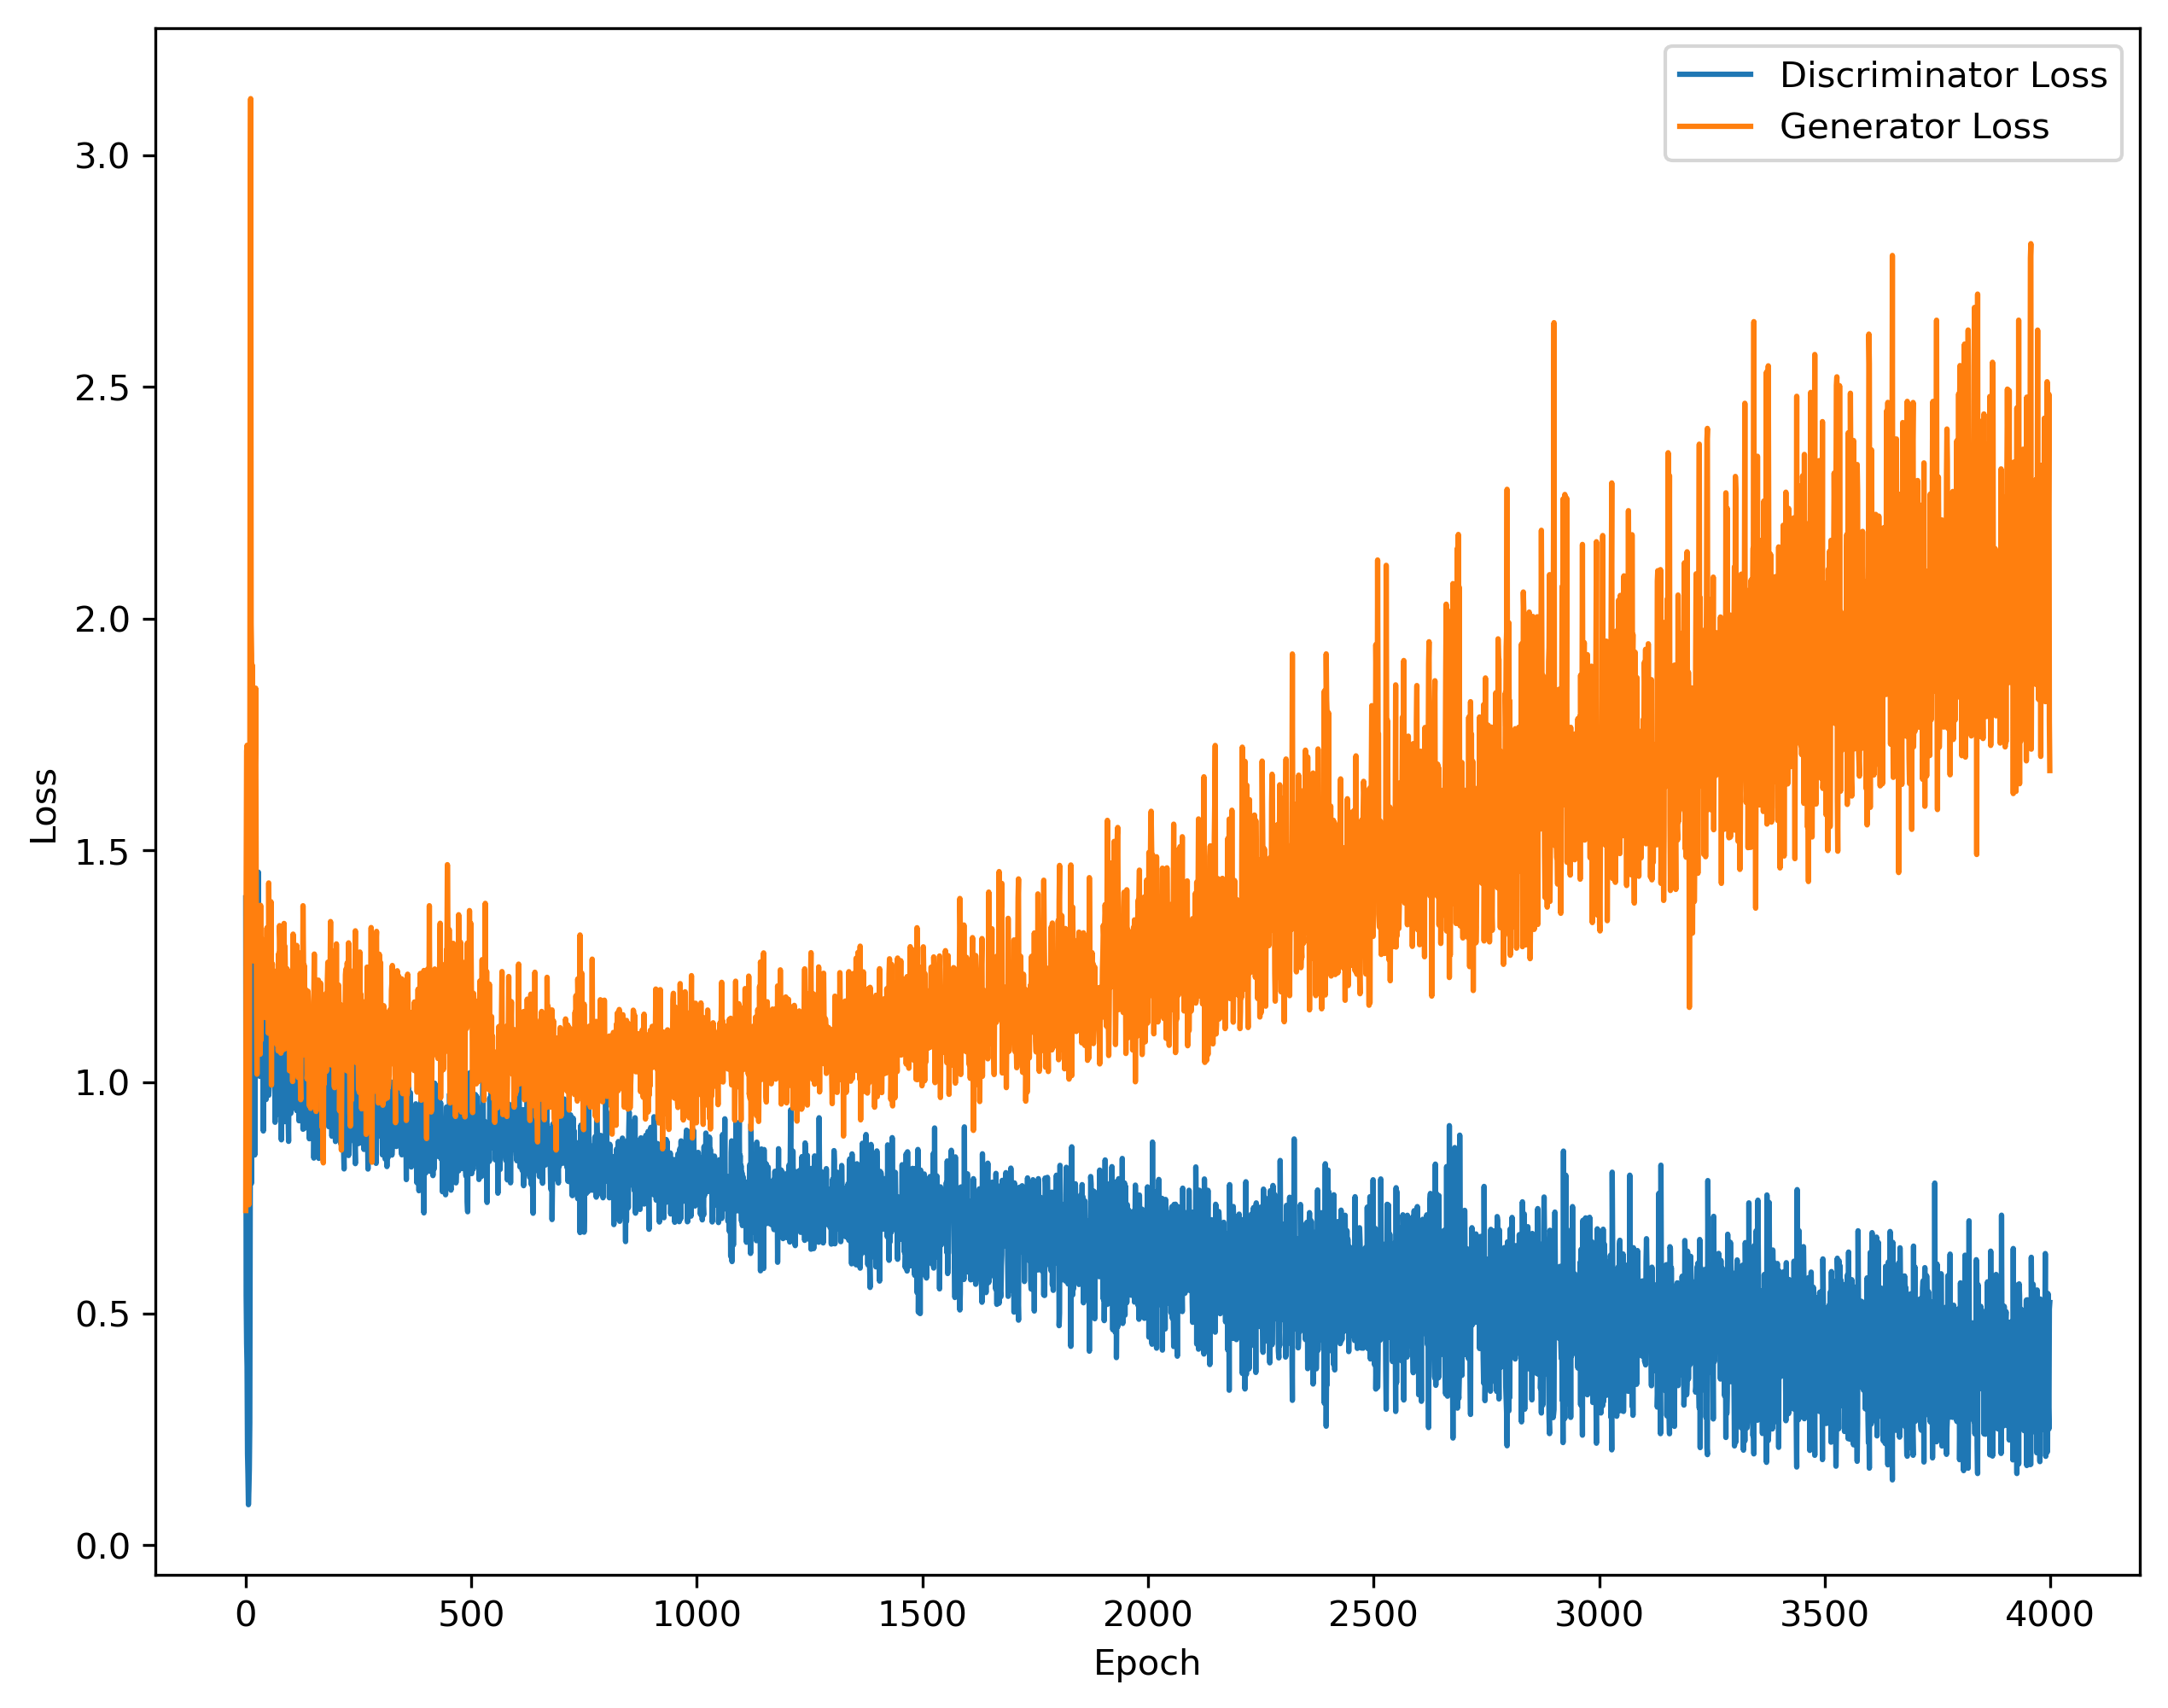

In [8]:
pokeGAN.plot_loss()

Analysis:

Well. The generator loss increased instead of decreasing. That should kinda say enough. It seems to have reached its peak around the 900 epochs mark. So taking a look at that:

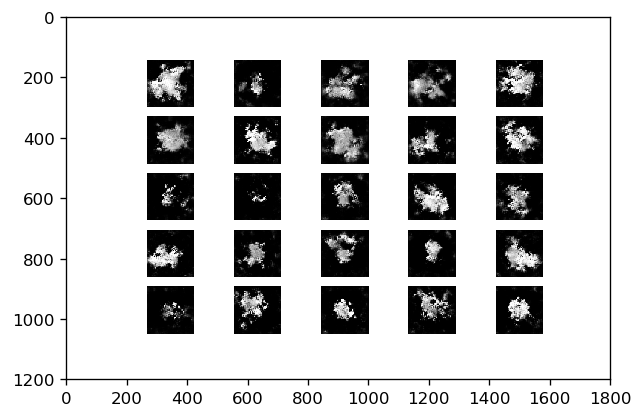

In [23]:
fig = plt.figure(dpi=120)
plt.imshow(load_img('output/pokeGAN_99.png'))

Well, seems nothing like a Pokemon. Just for closure, lets look at the final epoch's results.

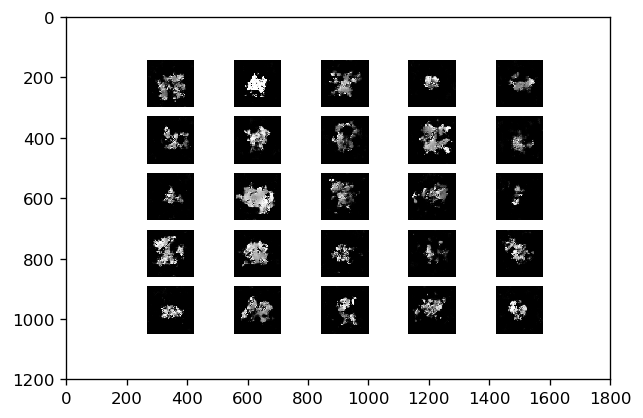

In [24]:
fig = plt.figure(dpi=120)
plt.imshow(load_img('output/pokeGAN_3999.png'))

This isn't much of a difference either honestly. I'm guessing our problem is the tiny amount of data we fed to it. Maybe augmentation will help.

#### Trial 2: 

Same parameters. Data augmentation done.

In [90]:
pokeGAN = PokeGAN(64, 64, 1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 17, 17, 64)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 17, 17, 64)        256       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 17, 17, 64)        0         
__________

In [91]:
pokeGAN.train(data, 4000, 64, 100)

C:\Users\akash\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 1.628406, acc.: 41.41%] [G loss: 0.411504]
1 [D loss: 0.866491, acc.: 50.00%] [G loss: 1.143269]
2 [D loss: 0.744096, acc.: 54.69%] [G loss: 1.431423]
3 [D loss: 0.540702, acc.: 73.44%] [G loss: 1.245572]
4 [D loss: 0.332108, acc.: 90.62%] [G loss: 0.824120]
5 [D loss: 0.157295, acc.: 99.22%] [G loss: 0.603477]
6 [D loss: 0.102791, acc.: 100.00%] [G loss: 0.452161]
7 [D loss: 0.134744, acc.: 96.88%] [G loss: 0.364628]
8 [D loss: 0.168675, acc.: 95.31%] [G loss: 0.391536]
9 [D loss: 0.382042, acc.: 81.25%] [G loss: 1.098994]
10 [D loss: 0.728967, acc.: 60.16%] [G loss: 2.591457]
11 [D loss: 1.823245, acc.: 10.94%] [G loss: 2.546044]
12 [D loss: 1.469940, acc.: 18.75%] [G loss: 1.935944]
13 [D loss: 1.264576, acc.: 26.56%] [G loss: 1.531018]
14 [D loss: 0.950392, acc.: 42.97%] [G loss: 1.386785]
15 [D loss: 1.192052, acc.: 38.28%] [G loss: 1.201175]
16 [D loss: 1.389049, acc.: 27.34%] [G loss: 1.388397]
17 [D loss: 1.537509, acc.: 21.88%] [G loss: 1.483999]
18 [D loss: 1.37694

149 [D loss: 0.892352, acc.: 41.41%] [G loss: 1.054846]
150 [D loss: 0.983104, acc.: 40.62%] [G loss: 1.170094]
151 [D loss: 0.993257, acc.: 39.06%] [G loss: 0.884867]
152 [D loss: 0.954408, acc.: 39.06%] [G loss: 0.842789]
153 [D loss: 1.000143, acc.: 41.41%] [G loss: 1.010075]
154 [D loss: 1.002225, acc.: 44.53%] [G loss: 1.246082]
155 [D loss: 1.074208, acc.: 34.38%] [G loss: 1.179896]
156 [D loss: 1.019945, acc.: 39.84%] [G loss: 1.139301]
157 [D loss: 1.070507, acc.: 33.59%] [G loss: 1.184599]
158 [D loss: 1.030704, acc.: 34.38%] [G loss: 1.093852]
159 [D loss: 1.095348, acc.: 35.94%] [G loss: 1.102837]
160 [D loss: 1.164626, acc.: 28.12%] [G loss: 1.113963]
161 [D loss: 1.003442, acc.: 40.62%] [G loss: 1.190840]
162 [D loss: 1.247242, acc.: 28.91%] [G loss: 0.959849]
163 [D loss: 0.987510, acc.: 35.94%] [G loss: 1.113225]
164 [D loss: 1.142531, acc.: 25.00%] [G loss: 1.089301]
165 [D loss: 1.013766, acc.: 25.00%] [G loss: 1.016293]
166 [D loss: 1.013898, acc.: 35.16%] [G loss: 1.

296 [D loss: 1.060158, acc.: 24.22%] [G loss: 0.958851]
297 [D loss: 0.997913, acc.: 34.38%] [G loss: 1.024598]
298 [D loss: 0.974124, acc.: 32.03%] [G loss: 1.078565]
299 [D loss: 0.917805, acc.: 32.81%] [G loss: 1.010928]
300 [D loss: 0.907803, acc.: 41.41%] [G loss: 1.071070]
301 [D loss: 0.933873, acc.: 39.84%] [G loss: 1.124705]
302 [D loss: 0.950472, acc.: 33.59%] [G loss: 1.093644]
303 [D loss: 0.830771, acc.: 41.41%] [G loss: 1.104691]
304 [D loss: 0.967704, acc.: 39.84%] [G loss: 0.943775]
305 [D loss: 0.929092, acc.: 37.50%] [G loss: 0.988007]
306 [D loss: 0.875713, acc.: 40.62%] [G loss: 0.947651]
307 [D loss: 0.969089, acc.: 34.38%] [G loss: 1.045660]
308 [D loss: 0.881477, acc.: 42.97%] [G loss: 1.145171]
309 [D loss: 0.932129, acc.: 38.28%] [G loss: 0.950922]
310 [D loss: 0.930410, acc.: 44.53%] [G loss: 1.073576]
311 [D loss: 0.935568, acc.: 32.81%] [G loss: 0.939423]
312 [D loss: 0.928576, acc.: 40.62%] [G loss: 1.074794]
313 [D loss: 0.861612, acc.: 42.19%] [G loss: 1.

443 [D loss: 0.927235, acc.: 37.50%] [G loss: 0.973437]
444 [D loss: 0.915442, acc.: 31.25%] [G loss: 0.986371]
445 [D loss: 0.938925, acc.: 34.38%] [G loss: 0.879207]
446 [D loss: 0.835133, acc.: 40.62%] [G loss: 0.987307]
447 [D loss: 0.919721, acc.: 34.38%] [G loss: 0.948397]
448 [D loss: 0.885858, acc.: 39.06%] [G loss: 0.950534]
449 [D loss: 0.957596, acc.: 34.38%] [G loss: 0.960379]
450 [D loss: 0.967826, acc.: 31.25%] [G loss: 1.035316]
451 [D loss: 0.874148, acc.: 39.06%] [G loss: 0.928664]
452 [D loss: 0.874992, acc.: 38.28%] [G loss: 1.070336]
453 [D loss: 0.860805, acc.: 41.41%] [G loss: 0.995612]
454 [D loss: 0.933132, acc.: 35.94%] [G loss: 1.044298]
455 [D loss: 0.891619, acc.: 38.28%] [G loss: 1.038719]
456 [D loss: 0.847201, acc.: 41.41%] [G loss: 1.096549]
457 [D loss: 0.912191, acc.: 39.06%] [G loss: 1.107568]
458 [D loss: 0.847365, acc.: 38.28%] [G loss: 1.092681]
459 [D loss: 0.924014, acc.: 39.84%] [G loss: 1.018628]
460 [D loss: 0.978585, acc.: 35.16%] [G loss: 0.

590 [D loss: 0.880515, acc.: 36.72%] [G loss: 1.054541]
591 [D loss: 0.962281, acc.: 32.81%] [G loss: 0.891854]
592 [D loss: 0.851454, acc.: 34.38%] [G loss: 0.894039]
593 [D loss: 0.915468, acc.: 34.38%] [G loss: 1.046347]
594 [D loss: 0.950841, acc.: 29.69%] [G loss: 0.991432]
595 [D loss: 0.879329, acc.: 38.28%] [G loss: 1.036875]
596 [D loss: 0.906742, acc.: 33.59%] [G loss: 0.977266]
597 [D loss: 0.876207, acc.: 37.50%] [G loss: 0.919040]
598 [D loss: 0.901179, acc.: 37.50%] [G loss: 0.983024]
599 [D loss: 0.868691, acc.: 44.53%] [G loss: 0.895962]
600 [D loss: 0.866369, acc.: 35.16%] [G loss: 1.000482]
601 [D loss: 0.909665, acc.: 32.81%] [G loss: 1.026248]
602 [D loss: 0.901962, acc.: 35.16%] [G loss: 0.890047]
603 [D loss: 0.838527, acc.: 37.50%] [G loss: 0.979731]
604 [D loss: 0.870239, acc.: 40.62%] [G loss: 0.882015]
605 [D loss: 0.910245, acc.: 33.59%] [G loss: 0.870417]
606 [D loss: 0.838720, acc.: 41.41%] [G loss: 0.901798]
607 [D loss: 0.897075, acc.: 31.25%] [G loss: 0.

737 [D loss: 0.878168, acc.: 30.47%] [G loss: 0.858251]
738 [D loss: 0.885627, acc.: 31.25%] [G loss: 0.815613]
739 [D loss: 0.868858, acc.: 39.84%] [G loss: 0.957584]
740 [D loss: 0.885556, acc.: 36.72%] [G loss: 0.806425]
741 [D loss: 0.811598, acc.: 45.31%] [G loss: 0.858054]
742 [D loss: 0.886398, acc.: 33.59%] [G loss: 0.878557]
743 [D loss: 0.929272, acc.: 25.78%] [G loss: 0.942673]
744 [D loss: 0.802640, acc.: 42.97%] [G loss: 0.737489]
745 [D loss: 0.783158, acc.: 46.09%] [G loss: 0.886914]
746 [D loss: 0.955942, acc.: 28.12%] [G loss: 0.889646]
747 [D loss: 0.831196, acc.: 41.41%] [G loss: 0.846127]
748 [D loss: 0.914433, acc.: 30.47%] [G loss: 0.988406]
749 [D loss: 0.916002, acc.: 32.03%] [G loss: 0.901941]
750 [D loss: 0.834601, acc.: 39.06%] [G loss: 0.870334]
751 [D loss: 0.764091, acc.: 46.88%] [G loss: 0.997569]
752 [D loss: 0.811699, acc.: 44.53%] [G loss: 0.930545]
753 [D loss: 0.877217, acc.: 30.47%] [G loss: 0.813657]
754 [D loss: 0.844640, acc.: 36.72%] [G loss: 0.

884 [D loss: 0.867476, acc.: 34.38%] [G loss: 0.870388]
885 [D loss: 0.814246, acc.: 39.06%] [G loss: 0.949842]
886 [D loss: 0.762663, acc.: 46.09%] [G loss: 0.921120]
887 [D loss: 0.855485, acc.: 42.97%] [G loss: 0.920830]
888 [D loss: 0.830385, acc.: 40.62%] [G loss: 0.896127]
889 [D loss: 0.839823, acc.: 37.50%] [G loss: 0.878196]
890 [D loss: 0.828601, acc.: 35.16%] [G loss: 0.887993]
891 [D loss: 0.799894, acc.: 42.97%] [G loss: 0.951212]
892 [D loss: 0.921975, acc.: 28.91%] [G loss: 0.906831]
893 [D loss: 0.851425, acc.: 36.72%] [G loss: 0.877548]
894 [D loss: 0.871894, acc.: 34.38%] [G loss: 0.959043]
895 [D loss: 0.831597, acc.: 38.28%] [G loss: 0.874391]
896 [D loss: 0.902596, acc.: 28.91%] [G loss: 0.861229]
897 [D loss: 0.860117, acc.: 34.38%] [G loss: 0.841862]
898 [D loss: 0.775036, acc.: 38.28%] [G loss: 0.850762]
899 [D loss: 0.818769, acc.: 41.41%] [G loss: 0.902611]
900 [D loss: 0.816186, acc.: 38.28%] [G loss: 0.886958]
901 [D loss: 0.825240, acc.: 37.50%] [G loss: 0.

1030 [D loss: 0.817365, acc.: 37.50%] [G loss: 0.829346]
1031 [D loss: 0.818529, acc.: 37.50%] [G loss: 0.862298]
1032 [D loss: 0.876051, acc.: 35.16%] [G loss: 0.943421]
1033 [D loss: 0.806533, acc.: 35.94%] [G loss: 0.864671]
1034 [D loss: 0.775281, acc.: 44.53%] [G loss: 0.852254]
1035 [D loss: 0.756402, acc.: 44.53%] [G loss: 0.938607]
1036 [D loss: 0.763771, acc.: 45.31%] [G loss: 0.936972]
1037 [D loss: 0.870817, acc.: 31.25%] [G loss: 0.811993]
1038 [D loss: 0.788467, acc.: 45.31%] [G loss: 0.811747]
1039 [D loss: 0.851843, acc.: 35.94%] [G loss: 0.860609]
1040 [D loss: 0.770795, acc.: 43.75%] [G loss: 0.879030]
1041 [D loss: 0.832395, acc.: 31.25%] [G loss: 0.841797]
1042 [D loss: 0.783186, acc.: 39.84%] [G loss: 0.797499]
1043 [D loss: 0.764158, acc.: 44.53%] [G loss: 0.878228]
1044 [D loss: 0.759727, acc.: 42.19%] [G loss: 0.906868]
1045 [D loss: 0.807659, acc.: 40.62%] [G loss: 0.846536]
1046 [D loss: 0.819227, acc.: 33.59%] [G loss: 0.857383]
1047 [D loss: 0.812432, acc.: 3

1174 [D loss: 0.845574, acc.: 44.53%] [G loss: 0.805972]
1175 [D loss: 0.862059, acc.: 28.12%] [G loss: 0.833564]
1176 [D loss: 0.811641, acc.: 32.81%] [G loss: 0.902678]
1177 [D loss: 0.801694, acc.: 33.59%] [G loss: 0.793843]
1178 [D loss: 0.824378, acc.: 34.38%] [G loss: 0.822662]
1179 [D loss: 0.818689, acc.: 34.38%] [G loss: 0.784729]
1180 [D loss: 0.811122, acc.: 36.72%] [G loss: 0.814331]
1181 [D loss: 0.776931, acc.: 42.19%] [G loss: 0.859928]
1182 [D loss: 0.814738, acc.: 38.28%] [G loss: 0.898722]
1183 [D loss: 0.846230, acc.: 31.25%] [G loss: 0.860547]
1184 [D loss: 0.805512, acc.: 37.50%] [G loss: 0.843730]
1185 [D loss: 0.855397, acc.: 28.91%] [G loss: 0.886328]
1186 [D loss: 0.843100, acc.: 39.84%] [G loss: 0.819221]
1187 [D loss: 0.800394, acc.: 37.50%] [G loss: 0.934762]
1188 [D loss: 0.797170, acc.: 41.41%] [G loss: 0.893260]
1189 [D loss: 0.807454, acc.: 32.03%] [G loss: 0.819309]
1190 [D loss: 0.786837, acc.: 41.41%] [G loss: 0.881432]
1191 [D loss: 0.808240, acc.: 3

1318 [D loss: 0.783284, acc.: 37.50%] [G loss: 0.835432]
1319 [D loss: 0.788652, acc.: 35.16%] [G loss: 0.804686]
1320 [D loss: 0.797047, acc.: 39.06%] [G loss: 0.744771]
1321 [D loss: 0.785820, acc.: 42.97%] [G loss: 0.896222]
1322 [D loss: 0.806893, acc.: 32.81%] [G loss: 0.804193]
1323 [D loss: 0.790205, acc.: 35.16%] [G loss: 0.863221]
1324 [D loss: 0.779423, acc.: 37.50%] [G loss: 0.765434]
1325 [D loss: 0.770354, acc.: 45.31%] [G loss: 0.863201]
1326 [D loss: 0.781551, acc.: 48.44%] [G loss: 0.850060]
1327 [D loss: 0.786089, acc.: 41.41%] [G loss: 0.844250]
1328 [D loss: 0.830666, acc.: 32.81%] [G loss: 0.795276]
1329 [D loss: 0.778884, acc.: 39.84%] [G loss: 0.784919]
1330 [D loss: 0.798879, acc.: 39.84%] [G loss: 0.841287]
1331 [D loss: 0.833801, acc.: 32.03%] [G loss: 0.820740]
1332 [D loss: 0.763661, acc.: 36.72%] [G loss: 0.773462]
1333 [D loss: 0.764560, acc.: 42.97%] [G loss: 0.813927]
1334 [D loss: 0.796645, acc.: 38.28%] [G loss: 0.836977]
1335 [D loss: 0.734778, acc.: 4

1462 [D loss: 0.791258, acc.: 41.41%] [G loss: 0.846524]
1463 [D loss: 0.844091, acc.: 30.47%] [G loss: 0.830713]
1464 [D loss: 0.784375, acc.: 35.16%] [G loss: 0.813841]
1465 [D loss: 0.776108, acc.: 42.97%] [G loss: 0.901459]
1466 [D loss: 0.758349, acc.: 41.41%] [G loss: 0.857928]
1467 [D loss: 0.790945, acc.: 36.72%] [G loss: 0.853093]
1468 [D loss: 0.798491, acc.: 35.94%] [G loss: 0.869517]
1469 [D loss: 0.843833, acc.: 29.69%] [G loss: 0.768695]
1470 [D loss: 0.735625, acc.: 44.53%] [G loss: 0.807410]
1471 [D loss: 0.815750, acc.: 36.72%] [G loss: 0.768623]
1472 [D loss: 0.739946, acc.: 45.31%] [G loss: 0.851125]
1473 [D loss: 0.787339, acc.: 39.84%] [G loss: 0.860791]
1474 [D loss: 0.783348, acc.: 46.09%] [G loss: 0.927381]
1475 [D loss: 0.703694, acc.: 54.69%] [G loss: 0.852533]
1476 [D loss: 0.734457, acc.: 46.88%] [G loss: 0.936300]
1477 [D loss: 0.792621, acc.: 36.72%] [G loss: 0.784904]
1478 [D loss: 0.753735, acc.: 45.31%] [G loss: 0.850349]
1479 [D loss: 0.751145, acc.: 4

1606 [D loss: 0.739419, acc.: 44.53%] [G loss: 0.865714]
1607 [D loss: 0.833742, acc.: 27.34%] [G loss: 0.785492]
1608 [D loss: 0.747823, acc.: 45.31%] [G loss: 0.856632]
1609 [D loss: 0.751823, acc.: 34.38%] [G loss: 0.853208]
1610 [D loss: 0.738708, acc.: 42.97%] [G loss: 0.744185]
1611 [D loss: 0.779523, acc.: 38.28%] [G loss: 0.661015]
1612 [D loss: 0.730438, acc.: 40.62%] [G loss: 0.779703]
1613 [D loss: 0.760435, acc.: 42.19%] [G loss: 0.842669]
1614 [D loss: 0.731578, acc.: 51.56%] [G loss: 0.761658]
1615 [D loss: 0.756213, acc.: 41.41%] [G loss: 0.810791]
1616 [D loss: 0.762709, acc.: 40.62%] [G loss: 0.892649]
1617 [D loss: 0.813909, acc.: 39.06%] [G loss: 0.838560]
1618 [D loss: 0.762033, acc.: 38.28%] [G loss: 0.824720]
1619 [D loss: 0.782651, acc.: 43.75%] [G loss: 0.826897]
1620 [D loss: 0.816328, acc.: 32.03%] [G loss: 0.784311]
1621 [D loss: 0.735245, acc.: 48.44%] [G loss: 0.804258]
1622 [D loss: 0.744739, acc.: 39.84%] [G loss: 0.793056]
1623 [D loss: 0.790692, acc.: 3

1750 [D loss: 0.764708, acc.: 44.53%] [G loss: 0.733498]
1751 [D loss: 0.797944, acc.: 36.72%] [G loss: 0.692053]
1752 [D loss: 0.718786, acc.: 54.69%] [G loss: 0.755467]
1753 [D loss: 0.714955, acc.: 49.22%] [G loss: 0.809744]
1754 [D loss: 0.795915, acc.: 32.81%] [G loss: 0.800733]
1755 [D loss: 0.773165, acc.: 33.59%] [G loss: 0.778548]
1756 [D loss: 0.772961, acc.: 36.72%] [G loss: 0.821204]
1757 [D loss: 0.745517, acc.: 44.53%] [G loss: 0.849442]
1758 [D loss: 0.738413, acc.: 47.66%] [G loss: 0.751233]
1759 [D loss: 0.743810, acc.: 42.19%] [G loss: 0.841399]
1760 [D loss: 0.765934, acc.: 46.88%] [G loss: 0.732858]
1761 [D loss: 0.774123, acc.: 37.50%] [G loss: 0.724423]
1762 [D loss: 0.775789, acc.: 39.84%] [G loss: 0.783261]
1763 [D loss: 0.692050, acc.: 53.91%] [G loss: 0.759584]
1764 [D loss: 0.805947, acc.: 29.69%] [G loss: 0.827794]
1765 [D loss: 0.713282, acc.: 47.66%] [G loss: 0.796155]
1766 [D loss: 0.737484, acc.: 40.62%] [G loss: 0.806440]
1767 [D loss: 0.636464, acc.: 6

1894 [D loss: 0.819137, acc.: 32.03%] [G loss: 0.700319]
1895 [D loss: 0.826894, acc.: 30.47%] [G loss: 0.767711]
1896 [D loss: 0.754759, acc.: 42.19%] [G loss: 0.765192]
1897 [D loss: 0.746444, acc.: 44.53%] [G loss: 0.761737]
1898 [D loss: 0.792468, acc.: 35.94%] [G loss: 0.722232]
1899 [D loss: 0.779646, acc.: 36.72%] [G loss: 0.775317]
1900 [D loss: 0.676158, acc.: 60.94%] [G loss: 0.759974]
1901 [D loss: 0.743495, acc.: 47.66%] [G loss: 0.731749]
1902 [D loss: 0.779485, acc.: 39.06%] [G loss: 0.789473]
1903 [D loss: 0.668705, acc.: 59.38%] [G loss: 0.782985]
1904 [D loss: 0.741989, acc.: 44.53%] [G loss: 0.676944]
1905 [D loss: 0.755017, acc.: 41.41%] [G loss: 0.763936]
1906 [D loss: 0.745181, acc.: 46.09%] [G loss: 0.799436]
1907 [D loss: 0.780010, acc.: 33.59%] [G loss: 0.787668]
1908 [D loss: 0.724970, acc.: 40.62%] [G loss: 0.783016]
1909 [D loss: 0.833396, acc.: 28.91%] [G loss: 0.776273]
1910 [D loss: 0.723458, acc.: 53.91%] [G loss: 0.800460]
1911 [D loss: 0.785519, acc.: 3

2038 [D loss: 0.735098, acc.: 44.53%] [G loss: 0.878715]
2039 [D loss: 0.765049, acc.: 43.75%] [G loss: 0.910565]
2040 [D loss: 0.723603, acc.: 48.44%] [G loss: 0.820242]
2041 [D loss: 0.768659, acc.: 33.59%] [G loss: 0.776274]
2042 [D loss: 0.786656, acc.: 42.19%] [G loss: 0.733690]
2043 [D loss: 0.779763, acc.: 32.81%] [G loss: 0.779526]
2044 [D loss: 0.715167, acc.: 52.34%] [G loss: 0.768998]
2045 [D loss: 0.677194, acc.: 53.91%] [G loss: 0.735650]
2046 [D loss: 0.787568, acc.: 40.62%] [G loss: 0.712507]
2047 [D loss: 0.677781, acc.: 63.28%] [G loss: 0.770626]
2048 [D loss: 0.764415, acc.: 41.41%] [G loss: 0.732419]
2049 [D loss: 0.916369, acc.: 19.53%] [G loss: 0.776365]
2050 [D loss: 0.724459, acc.: 53.91%] [G loss: 0.680977]
2051 [D loss: 0.690951, acc.: 57.81%] [G loss: 0.774818]
2052 [D loss: 0.755152, acc.: 42.97%] [G loss: 0.724740]
2053 [D loss: 0.729623, acc.: 52.34%] [G loss: 0.800627]
2054 [D loss: 0.749848, acc.: 39.06%] [G loss: 0.808328]
2055 [D loss: 0.857696, acc.: 2

2182 [D loss: 0.887782, acc.: 16.41%] [G loss: 0.683553]
2183 [D loss: 0.694887, acc.: 55.47%] [G loss: 0.812010]
2184 [D loss: 0.777757, acc.: 28.12%] [G loss: 0.830669]
2185 [D loss: 0.690037, acc.: 55.47%] [G loss: 0.828902]
2186 [D loss: 0.564249, acc.: 61.72%] [G loss: 0.741499]
2187 [D loss: 0.796478, acc.: 42.19%] [G loss: 0.619712]
2188 [D loss: 0.715344, acc.: 48.44%] [G loss: 0.635380]
2189 [D loss: 0.629887, acc.: 70.31%] [G loss: 0.800965]
2190 [D loss: 0.737487, acc.: 44.53%] [G loss: 0.743054]
2191 [D loss: 0.745552, acc.: 51.56%] [G loss: 0.886950]
2192 [D loss: 0.754605, acc.: 35.16%] [G loss: 0.738228]
2193 [D loss: 0.741756, acc.: 46.09%] [G loss: 0.658849]
2194 [D loss: 0.752915, acc.: 45.31%] [G loss: 0.727333]
2195 [D loss: 0.745753, acc.: 43.75%] [G loss: 0.866987]
2196 [D loss: 0.713729, acc.: 48.44%] [G loss: 0.804353]
2197 [D loss: 0.681961, acc.: 53.91%] [G loss: 0.850192]
2198 [D loss: 0.812492, acc.: 34.38%] [G loss: 0.690401]
2199 [D loss: 0.888580, acc.: 2

2326 [D loss: 0.753380, acc.: 33.59%] [G loss: 0.731571]
2327 [D loss: 0.779994, acc.: 32.81%] [G loss: 0.769290]
2328 [D loss: 0.741103, acc.: 45.31%] [G loss: 0.798178]
2329 [D loss: 0.637642, acc.: 64.06%] [G loss: 0.845982]
2330 [D loss: 0.742762, acc.: 48.44%] [G loss: 0.721006]
2331 [D loss: 0.766306, acc.: 35.16%] [G loss: 0.718030]
2332 [D loss: 0.716939, acc.: 46.88%] [G loss: 0.733666]
2333 [D loss: 0.732197, acc.: 45.31%] [G loss: 0.724215]
2334 [D loss: 0.799640, acc.: 33.59%] [G loss: 0.807166]
2335 [D loss: 0.709370, acc.: 50.00%] [G loss: 0.763867]
2336 [D loss: 0.719037, acc.: 45.31%] [G loss: 0.817406]
2337 [D loss: 0.746085, acc.: 42.97%] [G loss: 0.787739]
2338 [D loss: 0.714006, acc.: 44.53%] [G loss: 0.796369]
2339 [D loss: 0.740939, acc.: 37.50%] [G loss: 0.748806]
2340 [D loss: 0.780587, acc.: 34.38%] [G loss: 0.715447]
2341 [D loss: 0.837126, acc.: 20.31%] [G loss: 0.734814]
2342 [D loss: 0.747519, acc.: 39.84%] [G loss: 0.797595]
2343 [D loss: 0.964174, acc.: 1

2470 [D loss: 0.646718, acc.: 62.50%] [G loss: 0.846161]
2471 [D loss: 0.776404, acc.: 34.38%] [G loss: 0.812373]
2472 [D loss: 0.775230, acc.: 34.38%] [G loss: 0.811049]
2473 [D loss: 0.730518, acc.: 45.31%] [G loss: 0.806668]
2474 [D loss: 0.819219, acc.: 30.47%] [G loss: 0.794311]
2475 [D loss: 0.975764, acc.: 14.84%] [G loss: 0.712568]
2476 [D loss: 0.826026, acc.: 35.94%] [G loss: 0.634339]
2477 [D loss: 0.807223, acc.: 30.47%] [G loss: 0.708345]
2478 [D loss: 0.732973, acc.: 41.41%] [G loss: 0.836795]
2479 [D loss: 0.755665, acc.: 51.56%] [G loss: 0.769138]
2480 [D loss: 0.786598, acc.: 35.94%] [G loss: 0.817562]
2481 [D loss: 0.751056, acc.: 46.88%] [G loss: 0.601394]
2482 [D loss: 0.932672, acc.: 8.59%] [G loss: 0.631690]
2483 [D loss: 0.723757, acc.: 47.66%] [G loss: 0.751738]
2484 [D loss: 0.716045, acc.: 46.88%] [G loss: 0.699417]
2485 [D loss: 0.926413, acc.: 10.94%] [G loss: 0.650558]
2486 [D loss: 0.819032, acc.: 30.47%] [G loss: 0.745874]
2487 [D loss: 0.659902, acc.: 55

2614 [D loss: 0.762509, acc.: 42.97%] [G loss: 0.678465]
2615 [D loss: 0.754512, acc.: 36.72%] [G loss: 0.703315]
2616 [D loss: 0.740114, acc.: 27.34%] [G loss: 0.743991]
2617 [D loss: 0.771028, acc.: 37.50%] [G loss: 0.713695]
2618 [D loss: 0.821499, acc.: 22.66%] [G loss: 0.649275]
2619 [D loss: 0.783958, acc.: 22.66%] [G loss: 0.699920]
2620 [D loss: 0.743294, acc.: 41.41%] [G loss: 0.770109]
2621 [D loss: 0.746730, acc.: 37.50%] [G loss: 0.733786]
2622 [D loss: 0.725569, acc.: 49.22%] [G loss: 0.719874]
2623 [D loss: 0.752590, acc.: 37.50%] [G loss: 0.701510]
2624 [D loss: 0.812116, acc.: 23.44%] [G loss: 0.692531]
2625 [D loss: 0.751296, acc.: 40.62%] [G loss: 0.736782]
2626 [D loss: 0.759512, acc.: 38.28%] [G loss: 0.693043]
2627 [D loss: 0.756233, acc.: 39.06%] [G loss: 0.689421]
2628 [D loss: 0.775325, acc.: 39.84%] [G loss: 0.738606]
2629 [D loss: 0.654142, acc.: 64.06%] [G loss: 0.763550]
2630 [D loss: 0.743232, acc.: 39.84%] [G loss: 0.776366]
2631 [D loss: 0.734358, acc.: 4

2758 [D loss: 0.731416, acc.: 44.53%] [G loss: 0.683780]
2759 [D loss: 0.724145, acc.: 48.44%] [G loss: 0.711716]
2760 [D loss: 0.637006, acc.: 67.19%] [G loss: 0.717856]
2761 [D loss: 0.768670, acc.: 34.38%] [G loss: 0.725806]
2762 [D loss: 0.721484, acc.: 41.41%] [G loss: 0.670227]
2763 [D loss: 0.705754, acc.: 51.56%] [G loss: 0.649591]
2764 [D loss: 0.737381, acc.: 46.09%] [G loss: 0.665710]
2765 [D loss: 0.699964, acc.: 53.12%] [G loss: 0.720942]
2766 [D loss: 0.730228, acc.: 49.22%] [G loss: 0.669244]
2767 [D loss: 0.670501, acc.: 53.91%] [G loss: 0.772731]
2768 [D loss: 0.790770, acc.: 35.94%] [G loss: 0.725846]
2769 [D loss: 0.684132, acc.: 59.38%] [G loss: 0.760185]
2770 [D loss: 0.737634, acc.: 44.53%] [G loss: 0.742508]
2771 [D loss: 0.712568, acc.: 54.69%] [G loss: 0.787460]
2772 [D loss: 0.922668, acc.: 9.38%] [G loss: 0.739072]
2773 [D loss: 0.695114, acc.: 56.25%] [G loss: 0.652793]
2774 [D loss: 0.794591, acc.: 36.72%] [G loss: 0.670191]
2775 [D loss: 0.910897, acc.: 9.

2902 [D loss: 0.764870, acc.: 35.16%] [G loss: 0.758185]
2903 [D loss: 0.735096, acc.: 40.62%] [G loss: 0.754144]
2904 [D loss: 0.754036, acc.: 36.72%] [G loss: 0.792434]
2905 [D loss: 0.735751, acc.: 43.75%] [G loss: 0.744344]
2906 [D loss: 0.720906, acc.: 47.66%] [G loss: 0.790271]
2907 [D loss: 0.775782, acc.: 32.03%] [G loss: 0.775562]
2908 [D loss: 0.699577, acc.: 52.34%] [G loss: 0.688631]
2909 [D loss: 0.872119, acc.: 20.31%] [G loss: 0.755721]
2910 [D loss: 0.728704, acc.: 42.97%] [G loss: 0.669816]
2911 [D loss: 0.710571, acc.: 48.44%] [G loss: 0.771912]
2912 [D loss: 0.786176, acc.: 28.12%] [G loss: 0.793481]
2913 [D loss: 0.700859, acc.: 53.12%] [G loss: 0.785662]
2914 [D loss: 0.771754, acc.: 32.03%] [G loss: 0.740650]
2915 [D loss: 0.703321, acc.: 51.56%] [G loss: 0.875431]
2916 [D loss: 0.699285, acc.: 46.09%] [G loss: 0.776893]
2917 [D loss: 0.759536, acc.: 35.94%] [G loss: 0.737529]
2918 [D loss: 0.735080, acc.: 49.22%] [G loss: 0.782533]
2919 [D loss: 0.768875, acc.: 4

3046 [D loss: 0.707566, acc.: 45.31%] [G loss: 0.695125]
3047 [D loss: 0.647491, acc.: 63.28%] [G loss: 0.692023]
3048 [D loss: 0.792626, acc.: 35.16%] [G loss: 0.680335]
3049 [D loss: 0.765976, acc.: 42.19%] [G loss: 0.663159]
3050 [D loss: 0.771581, acc.: 42.19%] [G loss: 0.690712]
3051 [D loss: 0.689791, acc.: 61.72%] [G loss: 0.790432]
3052 [D loss: 0.672363, acc.: 54.69%] [G loss: 0.676437]
3053 [D loss: 0.728237, acc.: 50.78%] [G loss: 0.679236]
3054 [D loss: 0.744662, acc.: 42.19%] [G loss: 0.738292]
3055 [D loss: 0.746906, acc.: 42.19%] [G loss: 0.784859]
3056 [D loss: 0.652994, acc.: 60.94%] [G loss: 0.752432]
3057 [D loss: 0.708066, acc.: 57.81%] [G loss: 0.725598]
3058 [D loss: 0.642964, acc.: 64.06%] [G loss: 0.704934]
3059 [D loss: 0.741538, acc.: 39.84%] [G loss: 0.710502]
3060 [D loss: 0.791676, acc.: 25.78%] [G loss: 0.827690]
3061 [D loss: 0.770381, acc.: 42.97%] [G loss: 0.727141]
3062 [D loss: 0.649145, acc.: 67.19%] [G loss: 0.781306]
3063 [D loss: 0.817212, acc.: 2

3190 [D loss: 0.706422, acc.: 57.03%] [G loss: 0.745095]
3191 [D loss: 0.710695, acc.: 53.91%] [G loss: 0.796666]
3192 [D loss: 0.734295, acc.: 35.16%] [G loss: 0.774792]
3193 [D loss: 0.787471, acc.: 35.16%] [G loss: 0.713001]
3194 [D loss: 0.630759, acc.: 60.94%] [G loss: 0.852966]
3195 [D loss: 0.787666, acc.: 38.28%] [G loss: 0.723732]
3196 [D loss: 0.726568, acc.: 46.88%] [G loss: 0.800200]
3197 [D loss: 0.582200, acc.: 64.84%] [G loss: 0.866435]
3198 [D loss: 0.745399, acc.: 42.97%] [G loss: 0.736733]
3199 [D loss: 0.795655, acc.: 35.94%] [G loss: 0.673361]
3200 [D loss: 0.683466, acc.: 60.94%] [G loss: 0.921812]
3201 [D loss: 0.668498, acc.: 60.94%] [G loss: 0.764052]
3202 [D loss: 0.833771, acc.: 19.53%] [G loss: 0.761528]
3203 [D loss: 0.742244, acc.: 39.84%] [G loss: 0.705188]
3204 [D loss: 0.728505, acc.: 43.75%] [G loss: 0.778885]
3205 [D loss: 0.753572, acc.: 35.94%] [G loss: 0.786958]
3206 [D loss: 0.790037, acc.: 53.12%] [G loss: 0.758042]
3207 [D loss: 0.752486, acc.: 4

3334 [D loss: 0.779118, acc.: 28.91%] [G loss: 0.752920]
3335 [D loss: 0.758982, acc.: 37.50%] [G loss: 0.677788]
3336 [D loss: 0.723091, acc.: 42.19%] [G loss: 0.790243]
3337 [D loss: 0.759973, acc.: 34.38%] [G loss: 0.732571]
3338 [D loss: 0.690807, acc.: 56.25%] [G loss: 0.719675]
3339 [D loss: 0.753383, acc.: 39.84%] [G loss: 0.702327]
3340 [D loss: 0.731889, acc.: 39.06%] [G loss: 0.661493]
3341 [D loss: 0.922012, acc.: 10.16%] [G loss: 0.694878]
3342 [D loss: 0.793157, acc.: 38.28%] [G loss: 0.670022]
3343 [D loss: 0.782831, acc.: 32.81%] [G loss: 0.647160]
3344 [D loss: 0.777098, acc.: 46.88%] [G loss: 0.682820]
3345 [D loss: 0.750614, acc.: 42.19%] [G loss: 0.681507]
3346 [D loss: 0.685663, acc.: 63.28%] [G loss: 0.764168]
3347 [D loss: 0.763407, acc.: 39.84%] [G loss: 0.725903]
3348 [D loss: 0.758777, acc.: 37.50%] [G loss: 0.822723]
3349 [D loss: 0.806204, acc.: 28.12%] [G loss: 0.736937]
3350 [D loss: 0.746599, acc.: 39.06%] [G loss: 0.726345]
3351 [D loss: 0.684368, acc.: 5

3478 [D loss: 0.692815, acc.: 54.69%] [G loss: 0.659498]
3479 [D loss: 0.670312, acc.: 62.50%] [G loss: 0.757511]
3480 [D loss: 0.733564, acc.: 42.19%] [G loss: 0.636776]
3481 [D loss: 0.753096, acc.: 44.53%] [G loss: 0.631237]
3482 [D loss: 0.816626, acc.: 28.12%] [G loss: 0.660675]
3483 [D loss: 0.745419, acc.: 46.88%] [G loss: 0.656031]
3484 [D loss: 0.678170, acc.: 48.44%] [G loss: 0.676519]
3485 [D loss: 0.680460, acc.: 50.78%] [G loss: 0.707515]
3486 [D loss: 0.762078, acc.: 36.72%] [G loss: 0.643971]
3487 [D loss: 0.714971, acc.: 49.22%] [G loss: 0.676008]
3488 [D loss: 0.874958, acc.: 18.75%] [G loss: 0.727692]
3489 [D loss: 0.699993, acc.: 50.78%] [G loss: 0.752294]
3490 [D loss: 0.781833, acc.: 28.91%] [G loss: 0.765379]
3491 [D loss: 0.734202, acc.: 37.50%] [G loss: 0.883460]
3492 [D loss: 0.638499, acc.: 60.94%] [G loss: 0.848852]
3493 [D loss: 0.837852, acc.: 24.22%] [G loss: 0.823066]
3494 [D loss: 0.945375, acc.: 17.97%] [G loss: 0.669301]
3495 [D loss: 0.644222, acc.: 7

3622 [D loss: 0.765942, acc.: 32.81%] [G loss: 0.706227]
3623 [D loss: 0.689596, acc.: 60.16%] [G loss: 0.706607]
3624 [D loss: 0.725446, acc.: 45.31%] [G loss: 0.788880]
3625 [D loss: 0.743951, acc.: 42.19%] [G loss: 0.752260]
3626 [D loss: 0.745795, acc.: 47.66%] [G loss: 0.745098]
3627 [D loss: 0.735368, acc.: 39.84%] [G loss: 0.731561]
3628 [D loss: 0.724469, acc.: 43.75%] [G loss: 0.773083]
3629 [D loss: 0.715530, acc.: 53.91%] [G loss: 0.750976]
3630 [D loss: 0.761716, acc.: 39.06%] [G loss: 0.667702]
3631 [D loss: 0.729974, acc.: 50.00%] [G loss: 0.664847]
3632 [D loss: 0.757070, acc.: 32.81%] [G loss: 0.709496]
3633 [D loss: 0.802998, acc.: 32.81%] [G loss: 0.678786]
3634 [D loss: 0.785067, acc.: 38.28%] [G loss: 0.714020]
3635 [D loss: 0.713806, acc.: 46.88%] [G loss: 0.676977]
3636 [D loss: 0.744526, acc.: 34.38%] [G loss: 0.721445]
3637 [D loss: 0.727598, acc.: 50.78%] [G loss: 0.698018]
3638 [D loss: 0.765300, acc.: 39.84%] [G loss: 0.757517]
3639 [D loss: 0.805388, acc.: 1

3766 [D loss: 0.692993, acc.: 57.03%] [G loss: 0.741232]
3767 [D loss: 0.699464, acc.: 52.34%] [G loss: 0.859632]
3768 [D loss: 0.721002, acc.: 44.53%] [G loss: 0.690190]
3769 [D loss: 0.673790, acc.: 59.38%] [G loss: 0.769546]
3770 [D loss: 0.699761, acc.: 57.03%] [G loss: 0.873177]
3771 [D loss: 0.707438, acc.: 44.53%] [G loss: 0.782034]
3772 [D loss: 0.747424, acc.: 43.75%] [G loss: 0.810043]
3773 [D loss: 0.657492, acc.: 59.38%] [G loss: 0.843076]
3774 [D loss: 0.813807, acc.: 27.34%] [G loss: 0.692554]
3775 [D loss: 0.732165, acc.: 40.62%] [G loss: 0.744313]
3776 [D loss: 0.697251, acc.: 57.03%] [G loss: 0.768806]
3777 [D loss: 0.715216, acc.: 53.12%] [G loss: 0.799091]
3778 [D loss: 0.747934, acc.: 38.28%] [G loss: 0.757673]
3779 [D loss: 0.770506, acc.: 28.91%] [G loss: 0.779743]
3780 [D loss: 0.910144, acc.: 25.00%] [G loss: 0.751104]
3781 [D loss: 0.781722, acc.: 36.72%] [G loss: 0.692215]
3782 [D loss: 0.737850, acc.: 40.62%] [G loss: 0.689036]
3783 [D loss: 0.713457, acc.: 5

3910 [D loss: 0.784012, acc.: 36.72%] [G loss: 0.789817]
3911 [D loss: 0.701459, acc.: 44.53%] [G loss: 0.818733]
3912 [D loss: 0.704480, acc.: 50.00%] [G loss: 0.879655]
3913 [D loss: 0.765158, acc.: 42.97%] [G loss: 0.872672]
3914 [D loss: 0.742220, acc.: 40.62%] [G loss: 0.857444]
3915 [D loss: 0.751797, acc.: 40.62%] [G loss: 0.842091]
3916 [D loss: 0.794885, acc.: 32.03%] [G loss: 0.781668]
3917 [D loss: 0.709956, acc.: 44.53%] [G loss: 0.800811]
3918 [D loss: 0.708072, acc.: 44.53%] [G loss: 0.866185]
3919 [D loss: 0.764661, acc.: 39.84%] [G loss: 0.879993]
3920 [D loss: 0.725741, acc.: 45.31%] [G loss: 0.807829]
3921 [D loss: 0.750667, acc.: 46.88%] [G loss: 0.755134]
3922 [D loss: 0.805125, acc.: 28.91%] [G loss: 0.752725]
3923 [D loss: 0.730607, acc.: 46.09%] [G loss: 0.728934]
3924 [D loss: 0.680494, acc.: 52.34%] [G loss: 0.748856]
3925 [D loss: 0.696254, acc.: 55.47%] [G loss: 0.765991]
3926 [D loss: 0.709948, acc.: 44.53%] [G loss: 0.807137]
3927 [D loss: 0.799998, acc.: 3

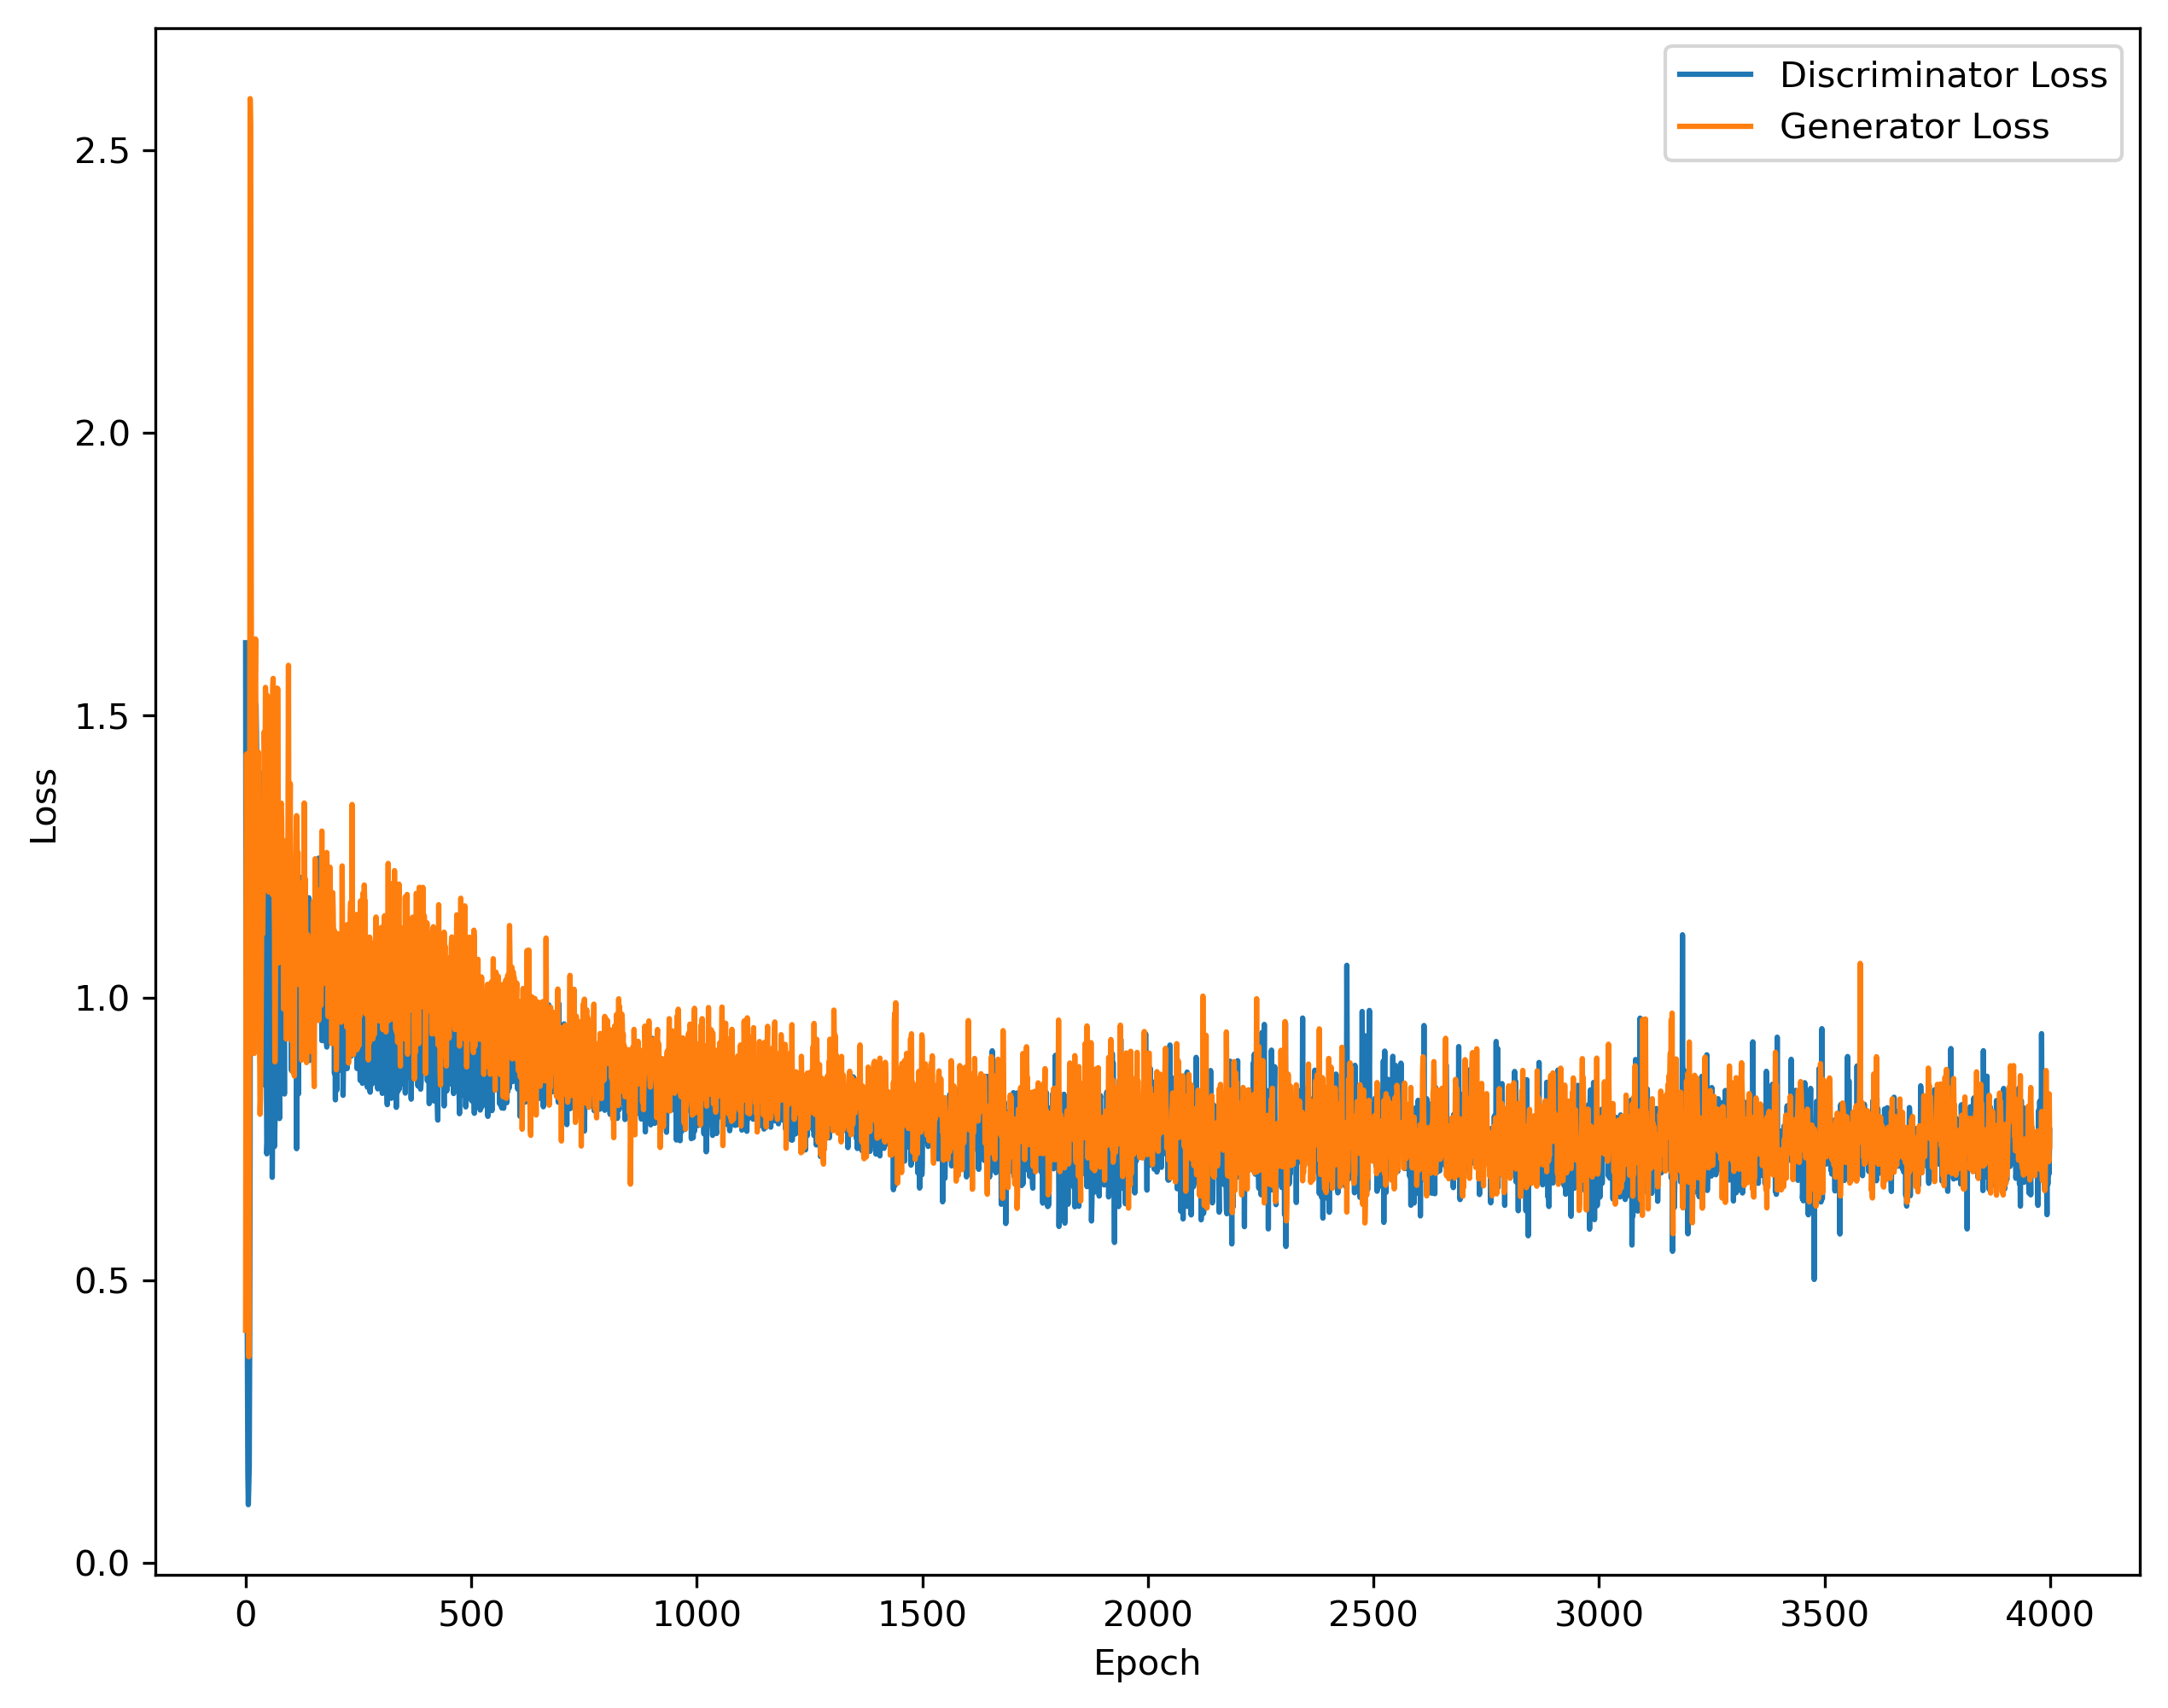

In [92]:
pokeGAN.plot_loss()

In [ ]:
fig = plt.figure(dpi=120)
plt.imshow(load_img('output/pokeGAN_99.png'))